# Libraries

In [263]:
import jenkspy
import os
from kneed import KneeLocator
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

# Common Functions

In [264]:
def get_id_list(n):
  id_list = []
  for i in range(1, n+1):
    id_list.append('P'+str(i))
  return id_list

# Location

In [271]:
# loc_root = 'E:/UVA One Drive-Asus/OneDrive - University of Virginia/'
bool_number_of_change_cal = False # Make it true when you are 
loc_root = 'C:/Users/wyd2hu/OneDrive - University of Virginia/'
loc_root_features_tiles_18 = loc_root+"Hridita/Rhythms/Findings/Tiles19_HeartRatePPG.xlsx"

# Identifying the changes in Rhythm 

In [272]:
def visualize_by_scatter(x_data, y_data,):
    
    bar_fig = go.Scatter(x=x_data, y=y_data)
    
    layout = go.Layout(
      title=go.layout.Title(text='', x=0),
      xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
      text="Participant", font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),

      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text= 'Break point',
      font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),
      legend=dict(orientation="h", x=0.3, y=1.1,  font=dict(family='Times New Roman', size=18), bgcolor='#FFFFFF'),
    
      plot_bgcolor = '#FFFFFF')
    fig = go.Figure(bar_fig, layout=layout)
    # fig.add_shape(type="line", x0=4, y0=y_min, x1=4, y1=y_max, line=dict(color='#000000', width=0.8, dash="dashdot"))
    fig.show()

In [274]:
df_rhy_tiles18 = pd.ExcelFile(loc_root_features_tiles_18)
id_list = df_rhy_tiles18.sheet_names

print('Should be equal', len(id_list), len(set(id_list)))
exclusion_list_tiles_18 = ['91297102-4775-4ea1-a10d-4',  'e3e5e4aa-5950-4f1f-915c-c', 
                        '41f2fcc5-e1a6-42d0-9b51-6',  'f30085f9-fdb0-49fb-b242-2',  
                        'fb3a4dd7-3cb5-438e-a75d-2',  '32de9693-b5b6-4292-addd-2',  
                        '24166136-6ee3-4521-abaf-9',  '1b1bcdb5-00eb-4a8c-8c05-a',  '2d05ec74-7279-4b26-b3ec-d',  
                        '3bdb1a29-023b-4fb5-8f49-6',  'a8800ef0-619c-4a3c-af5b-d']
exclusion_list_tiles_19 = ['4f91d234-b726-497b-aa81-d', '6df6f668-c75c-4264-9e97-3', 'd34aefad-d744-4462-8a77-c' 
                           '89209220-8ecf-4cd6-a9a4-a', '8dde8abc-014e-480a-9a07-c', '89209220-8ecf-4cd6-a9a4-a',
                          'a3df0da8-33d9-463b-babd-5', 'a9b3538d-491a-4615-ad89-c', 'ce871d21-38ba-4875-882f-0',
                          'd34aefad-d744-4462-8a77-c', 'ebf4f216-2e6a-4dd2-9266-e']

if 'Tiles18' in loc_root_features_tiles_18:
    change_file_name = 'tiles_18_n_change.xlsx'
    exclusion_list = exclusion_list_tiles_18
    list_breakpoint_range = list(range(2, 21))
else:
    change_file_name = 'tiles_19_n_change.xlsx'
    exclusion_list = exclusion_list_tiles_19
    list_breakpoint_range = list(range(2, 9))
print(change_file_name)

data_list_n_change = []
all_parti_threshold_x = []
all_parti_threshold_y = []

df_violin = pd.DataFrame()

for stable_breakpoint in list_breakpoint_range:
    single_violin_data = []
    for p_id in id_list:

        # if '2d05ec74-7279-4b26-b3ec-d' in p_id:
        if p_id not in exclusion_list: #   0e33f78a-7064-44ff-a8a4-7, 14eb688e-385b-4d6c-8cc1-0,  16812063-e5df-4657-b86c-5
            print(stable_breakpoint, p_id)
        
            threshold_x = []
            threshold_y = []

            df_rhy_tiles18 = pd.read_excel(loc_root_features_tiles_18, p_id)
            df_rhy_tiles18 = df_rhy_tiles18.iloc[1:] # first row (0) contains NaN values. Not an issue, BTW.
            first_time = df_rhy_tiles18.iloc[0]["N_Times"] # N_Times column contains the data of the nth (N) week
            last_time = df_rhy_tiles18.iloc[-1]["N_Times"]
    
            # print(p_id, 'DF size', df_rhy_tiles18.shape)
    
            step =  3 # steps to move. e.g., if it is 3, we are inferring changes of next 6 days (3: in each point, there is data of 2 days)
            last_index = stable_breakpoint # how many weeks' data are used for estimtaing rhythm as baseline

            if bool_number_of_change_cal:
                n_times = math.ceil((last_time - last_index) / step) + 1 # +1: let's say, there are 10 instances. Then, with a step of 3 and initial instance of 7 should make the total number of iterations 2
            else:
                n_times = math.ceil((last_time - last_index) / step) # ceil: e.g., 10 instances, intial 5 and step 4. Then, we need 5+4, 5+4 + 1
            n_counter = last_index + 1 # 2 means week after 8 days.

            for i_time in range(1, n_times+1):
                threshold_x.append(i_time) # data in each iteration

                if bool_number_of_change_cal:
                    df_sub_rhy = df_rhy_tiles18.iloc[list(range(0, stable_breakpoint))].copy() # can not be last_index+1 since you are starting from 0 and there are df_rhy_tiles18.shape[0]-1 values.
                else:
                    df_sub_rhy = df_rhy_tiles18.iloc[list(range(0, last_index))].copy() # can not be last_index+1 since you are starting from 0 and there are df_rhy_tiles18.shape[0]-1 values.
                
                if df_sub_rhy.shape[0] > 1: # if there is a week (after getting the sub dataframe df_sub_rhy) where there is just 1 instance, we can not move since we will not be able to find out the knee
                        break_points = jenkspy.jenks_breaks(df_sub_rhy["correct_acrophase"], n_classes=2)
                        print(p_id, 'DF size', df_rhy_tiles18.shape, break_points[1])
                        threshold_y.append(break_points[1])
                        
                        if ((last_index + step) <= df_rhy_tiles18.shape[0]): # just checking whether there are 3 (step) elements next to be retrieved
                            df_next_n_rhythm = df_rhy_tiles18.iloc[list(range(last_index, last_index+step))].copy()
                            last_index += step
                        else: # otherwise, we are taking all the remaining values
                            df_next_n_rhythm = df_rhy_tiles18.iloc[list(range(last_index, df_rhy_tiles18.shape[0]))].copy()
                            last_index = df_rhy_tiles18.shape[0]
                        
                        n_change = df_next_n_rhythm[df_next_n_rhythm['correct_acrophase'] > (break_points[1] + 0.1)].shape[0]
                        n_change += df_next_n_rhythm[df_next_n_rhythm['correct_acrophase'] < (break_points[1] - 0.1)].shape[0]
                        data_list_n_change.append([n_counter, n_change, break_points[1], p_id])
                        
                        n_counter += 1
                    # except Exception as e:
                    #     print('Problem 😒', df_sub_rhy.shape[0], df_sub_rhy.isna().sum().sum(), p_id)
                    #     print(e)
                    #     print(sorted(df_sub_rhy["correct_acrophase"]))
    
            # visualize_by_scatter(threshold_x, threshold_y)
            single_violin_data.append(np.mean(list(map(abs, threshold_y)) - abs(threshold_y[0])))
            all_parti_threshold_x.append(threshold_x)
            all_parti_threshold_y.append(threshold_y)            
    df_violin['S '+str(stable_breakpoint)] = single_violin_data

# Saving the data on the number of changes
df_n_change = pd.DataFrame(data=data_list_n_change, columns = ['n_counter', 'n_change', 'break_point','p_id'])
df_n_change.to_excel(loc_root + 'Hridita/Rhythms/Findings/Jenks/'+change_file_name, index=False)

Should be equal 49 49
tiles_19_n_change.xlsx
2 19329467-7c45-406b-b487-4
19329467-7c45-406b-b487-4 DF size (10, 10) -3.62988549559989
19329467-7c45-406b-b487-4 DF size (10, 10) -3.56290126437048
19329467-7c45-406b-b487-4 DF size (10, 10) -3.41582132924365
2 1db1552c-5703-4400-a38e-8
1db1552c-5703-4400-a38e-8 DF size (9, 10) -3.55081149411023
1db1552c-5703-4400-a38e-8 DF size (9, 10) -3.29095528533096
1db1552c-5703-4400-a38e-8 DF size (9, 10) -3.29095528533096
2 1f448103-5ef3-40e5-9131-a
1f448103-5ef3-40e5-9131-a DF size (9, 10) -6.2778151807977
1f448103-5ef3-40e5-9131-a DF size (9, 10) -3.4908790988829
1f448103-5ef3-40e5-9131-a DF size (9, 10) -3.01566310670359
2 21ab94d3-a40e-4c25-8410-e
21ab94d3-a40e-4c25-8410-e DF size (10, 10) -2.27654697337899
21ab94d3-a40e-4c25-8410-e DF size (10, 10) -2.27654697337899
21ab94d3-a40e-4c25-8410-e DF size (10, 10) -4.73370985365963
2 240b79e1-6f67-4e8d-b8ca-3
240b79e1-6f67-4e8d-b8ca-3 DF size (10, 10) -3.20784700473672
240b79e1-6f67-4e8d-b8ca-3 DF s

In [275]:
print(sum(df_n_change['n_change']))

1104


# Understanding the breakpoint for each P

-3.936512329330846


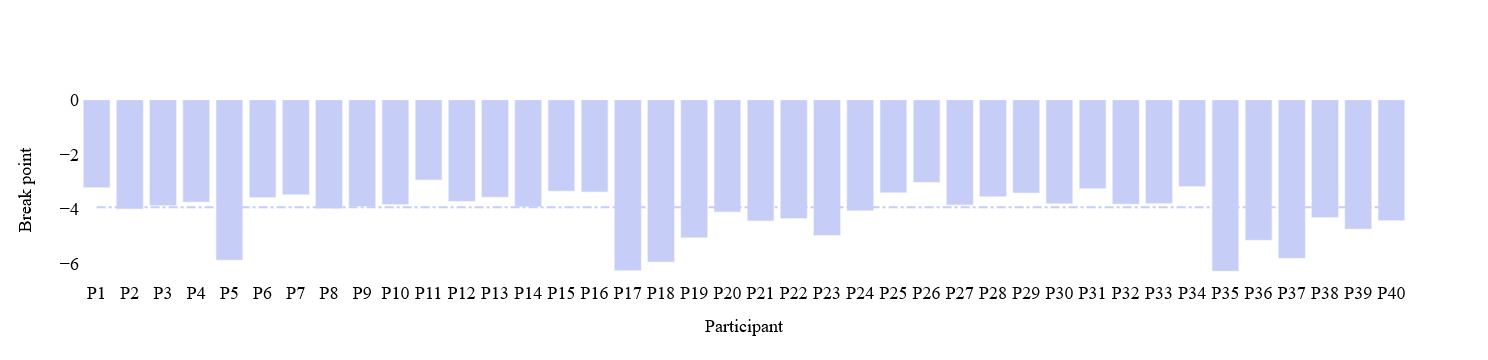

In [276]:
def visualize_by_bar_chart(x_data, y_data, y_axis):    
    bar_fig = go.Bar(x=x_data, y=y_data)
    print(np.mean(y_data))
    
    layout = go.Layout(
      title=go.layout.Title(text='', x=0),
      xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
      text="Participant", font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),

      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text= y_axis,
      font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),
      legend=dict(orientation="h", x=0.3, y=1.1,  font=dict(family='Times New Roman', size=18), bgcolor='#FFFFFF'),
        
      plot_bgcolor = '#FFFFFF')
    fig = go.Figure(bar_fig, layout=layout)
    fig.update_traces(marker_color='#C6CEF8')
    fig.add_shape(type="line", x0='P1', y0=np.mean(y_data), x1='P'+str(len(x_data)), y1=np.mean(y_data), line=dict(color='#C6CEF8', width=2, dash="dashdot"))
    fig.show()

if 'Tiles18' in loc_root_features_tiles_18:
    change_file_name = 'tiles_18_n_change.xlsx'
else:
    change_file_name = 'tiles_19_n_change.xlsx'
    
df_change = pd.read_excel(loc_root + 'Hridita/Rhythms/Findings/Jenks/'+change_file_name)
visualize_by_bar_chart(get_id_list(len(set(df_change['p_id']))), list(set(df_change['break_point'])), 'Break point')

40
2.071294559099437 0.8813979910976334


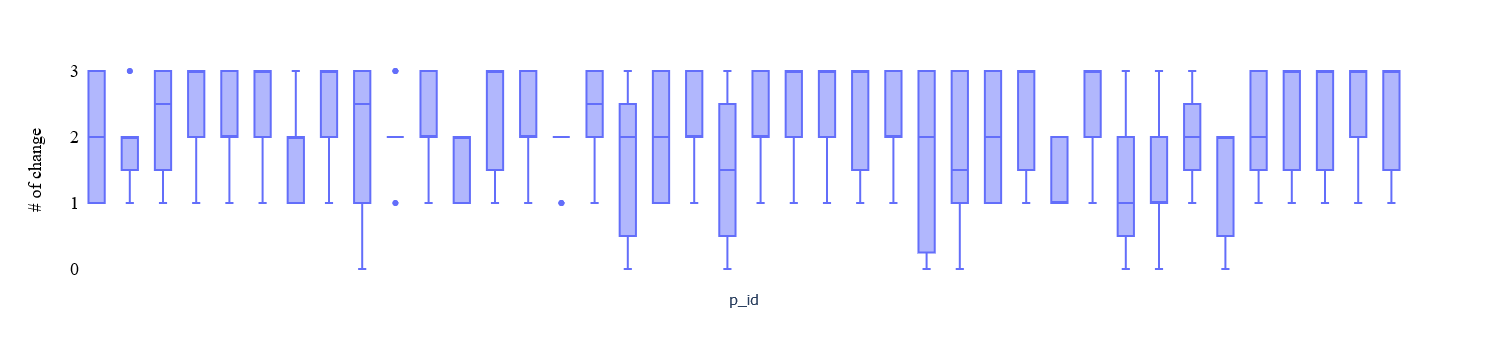

In [277]:
def visualize_by_box_plot(df, y_axis):
    print(np.mean(df['n_change']), np.std(df['n_change'], ddof=1))
    bar_fig = px.box(df, x="p_id", y="n_change")
    
    layout = go.Layout(
      title=go.layout.Title(text='', x=0),
      xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
      text="Participant", font=dict(family='Times New Roman', size=1, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=1)),

      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text= y_axis,
      font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),
      legend=dict(orientation="h", x=0.3, y=1.1,  font=dict(family='Times New Roman', size=18), bgcolor='#FFFFFF'),
        
      plot_bgcolor = '#FFFFFF')
    fig = go.Figure(bar_fig, layout=layout)
    # fig.update_traces(marker_color='#C6CEF8')
    fig.update_xaxes(showticklabels=False)
    fig.update_layout(
    {
        "plot_bgcolor": "#FFFFFF",
        'yaxis':go.layout.YAxis(title=go.layout.yaxis.Title(text= y_axis,
      font=dict(family='Times New Roman', size=18, color='#000000')),
      tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18))
    })
    # fig.add_shape(type="line", x0='P1', y0=np.mean(y_data), x1='P195', y1=np.mean(y_data), line=dict(color='#C6CEF8', width=2, dash="dashdot"))
    fig.show()

if 'Tiles18' in loc_root_features_tiles_18:
    change_file_name = 'tiles_18_n_change.xlsx'
else:
    change_file_name = 'tiles_19_n_change.xlsx'
    
df_change = pd.read_excel(loc_root + 'Hridita/Rhythms/Findings/Jenks/'+change_file_name)
print(len(set(df_change['p_id'])))
visualize_by_box_plot(df_change, '# of change')

# Finding the data instance # for "stable" break point

         S 2       S 3       S 4       S 5       S 6  S 7  S 8
0  -0.093683 -0.298384 -0.239458 -0.073540 -0.115741  0.0  0.0
1  -0.173237 -0.129928  0.000000  0.000000  0.000000  0.0  0.0
2  -2.016363 -0.781777 -0.781777 -0.237608  0.000000  0.0  0.0
3   0.819054  0.819054  0.000000  1.228581  1.228581  0.0  0.0
4   0.530585  1.879693  1.636623  1.402394 -0.453707  0.0  0.0
5  -0.032191  0.263330 -0.176103 -0.303920 -0.747202  0.0  0.0
6  -0.392018  0.000000  0.000000  0.000000  0.000000  0.0  0.0
7   0.000000 -0.090945 -0.136418  0.000000  0.136418  0.0  0.0
8   0.046778  0.046778 -0.153635 -0.153635 -0.153635  0.0  0.0
9  -0.094742  0.000000  0.000000  0.000000  0.000000  0.0  0.0
10  0.452283 -0.429851 -0.287733 -0.017711 -0.104734  0.0  0.0
11 -0.159679 -0.119759  0.000000  0.000000  0.000000  0.0  0.0
12 -0.479529  1.278586 -0.359647  0.000000  0.000000  0.0  0.0
13 -0.109941 -0.119726 -0.029814 -0.024656  0.000000  0.0  0.0
14 -0.039767  0.044723  0.096910  0.000000 -0.067085  0

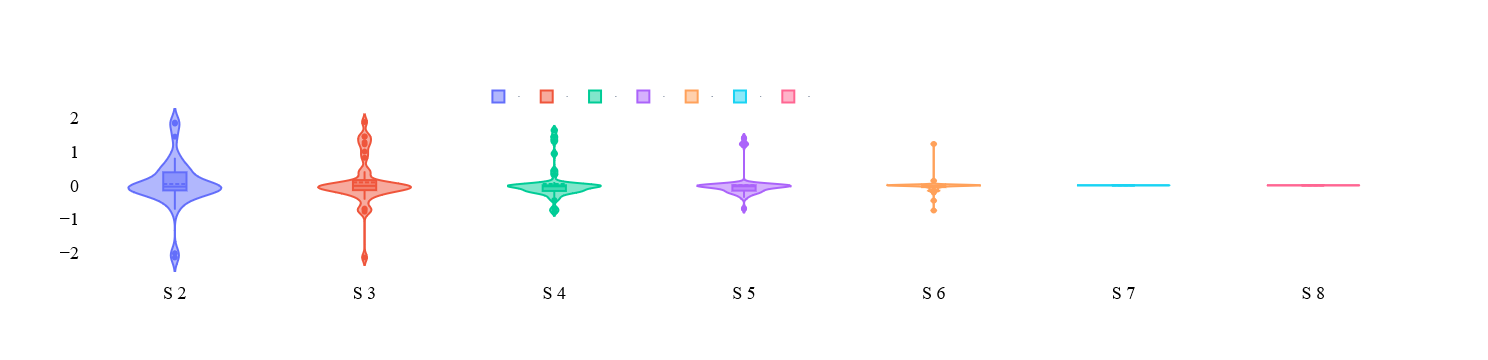

In [278]:
print(df_violin)
fig = go.Figure()
for stable_point in df_violin.columns:
    fig.add_trace(go.Violin(x=np.repeat(stable_point, df_violin.shape[0]),
                            y=df_violin[stable_point],
                            name=stable_point,
                            box_visible=True,
                            meanline_visible=True))
fig.update_layout({
        "plot_bgcolor": "#FFFFFF",
        'xaxis': go.layout.XAxis(title=go.layout.xaxis.Title(text="", font=dict(family='Times New Roman', size=18, color='#000000')),
                                 tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),
        'yaxis': go.layout.YAxis(title=go.layout.yaxis.Title(text="", font=dict(family='Times New Roman', size=18, color='#000000')),
                                 tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=18)),
        'legend': dict(orientation="h", x=0.3, y=1.1,  font=dict(family='Times New Roman', size=1), bgcolor='#FFFFFF')})
fig.show()

# Visualizing the number of times we calculated the rhythmic parameters

In [279]:
dic_id_n_instance = {}
for p_id in id_list:
    df_rhy_tiles18 = pd.read_excel(loc_root_features_tiles_18, p_id)
    dic_id_n_instance[p_id] = (df_rhy_tiles18.shape[0] - 1) # -1 since the first row contains NaN values (not an issue BTW)

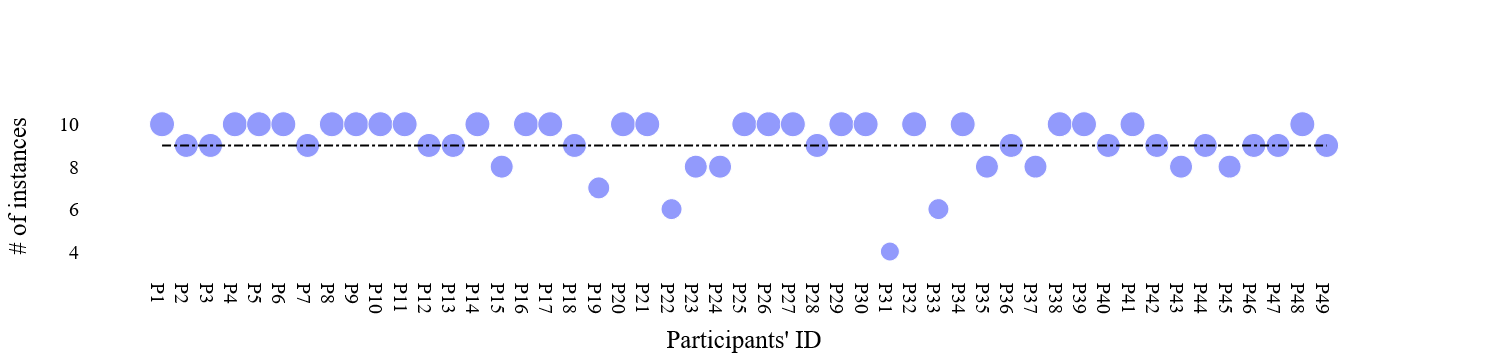

In [281]:
text_font_size = 25
tick_font_size = 20

plt_data_score = go.Scatter(
    x=get_id_list(len(dic_id_n_instance.values())), y= list(dic_id_n_instance.values()),
    mode='markers',
    marker_size = list(map(lambda score: score+15, dic_id_n_instance.values())))

layout = go.Layout(
    title=go.layout.Title(text='', x=0),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text='Participants\' ID ', font=dict(family='Times New Roman', size=text_font_size, color='#000000')),
    tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=tick_font_size)),

    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
    text='# of instances',
    font=dict(family='Times New Roman', size=text_font_size, color='#000000')),
    tickmode = 'array', color="#000000", tickfont=dict(family='Times New Roman', size=tick_font_size)),
    plot_bgcolor = '#FFFFFF')

fig = go.Figure(plt_data_score, layout=layout)
fig.add_shape(type="line", x0='P1', y0=9, x1='P49', y1=9, line=dict(color='#000000', width=2, dash="dashdot"))
fig

# Statistical Analysis

In [283]:
str_mean = 'mean'
str_std = 'std'
relation_data_tracker = set()
relation_list_df = []

In [284]:
def detect_outlier_z_score(value_list):
    outliers_indices = []
    threshold = 3  # A previous study remarks to use this threshold to detect outliers
    mean = np.mean(value_list)
    std = np.std(value_list, ddof=1)

    index = 0
    for value in value_list:
        z_score = (value - mean) / std
        if np.abs(z_score) > threshold:
            outliers_indices.append(index)
        index += 1

    return outliers_indices

In [285]:
def calculate_correlation(ds_name, depen_var, ind_var, n_missing, data_list1, data_list2):
  if len(data_list1) > 7:  # So that we can do the normaltest (N>=8 is required for this function).
      n_outlier = len(detect_outlier_z_score(data_list1))
      n_outlier += len(detect_outlier_z_score(data_list2))

      normality, p_norm_data1 = stats.normaltest(data_list1)
      normality, p_norm_data2 = stats.normaltest(data_list2)

      if p_norm_data1 > 0.05 and p_norm_data2 > 0.05 and n_outlier == 0:  # If ture, this means data are normally distributed and do not have any outlier
          cc, cc_p_value = stats.pearsonr(data_list1, data_list2)  # Pearson correlation
          r_text = "r="
      else:
          cc, cc_p_value = stats.spearmanr(data_list1, data_list2)  # Spearman correlation
          r_text = "rs="
  else:
      cc, cc_p_value = stats.spearmanr(data_list1, data_list2)  # Spearman correlation
      r_text = "rs="
  if (ds_name + depen_var + ind_var) not in relation_data_tracker:
      relation_list_df.append([ds_name, depen_var, ind_var, n_missing, r_text, cc, cc_p_value, len(data_list1)])
      relation_data_tracker.add(ds_name + depen_var + ind_var)
    
  return r_text, cc, cc_p_value, len(data_list1)

In [286]:
def relation_with_objective_data():
    loc_root_change = 'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Rhythms/Findings/Jenks/'

    for sleep_var in ['deep', 'light', 'rem', 'wake', 'restless']:
        df_step = pd.DataFrame()
        df_sleep = pd.DataFrame()
    
        for loc_data in ('C:/Users/wyd2hu/S2He/AudData/Tiles18/fitbit/sleep/', 'C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/fitbit/sleep-data/', 
                         'C:/Users/wyd2hu/S2He/AudData/Tiles18/fitbit/step-count/', 'C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/fitbit/step-count'):
            dic_id_sleep = {}

            ind_var = ''
            depen_var = 'n_change_std'
            ds_name = ''
            n_missing_values = 0

            for p_id in os.listdir(loc_data):
                if p_id.endswith('.gz'):
                    df_temp = pd.read_csv(os.path.join(loc_data, p_id), compression='gzip')
                    df_temp.dropna(inplace=True)
                    if 'step' in loc_data:
                        ind_var = "step_" + str_mean
                        dic_id_sleep[p_id[:25]] = df_temp['StepCount'].mean()
                    else:
                        ind_var = os.path.basename(loc_data) +'_count_'+ sleep_var
                        if 'Tiles18' in loc_data:
                            # dic_id_sleep[p_id[:25]] = np.std(df_temp['duration'], ddof=1)
                            dic_id_sleep[p_id[:25]] = df_temp['sleep_phase'].tolist().count(sleep_var)
                        else:
                            # dic_id_sleep[p_id[:25]] = np.std(df_temp['seconds'], ddof=1)
                            dic_id_sleep[p_id[:25]] = df_temp['level'].tolist().count(sleep_var)

            if 'Tiles18' in loc_data:
                ds_name = 'Tiles18'
                n_change_file = 'tiles_18_n_change.xlsx'
            else:
                ds_name = 'Tiles19'
                n_change_file = 'tiles_19_n_change.xlsx'

            df_data = pd.DataFrame(dic_id_sleep.items(), columns=['p_id', 'data'])
            df_change = pd.read_excel(os.path.join(loc_root_change, n_change_file)).groupby(['p_id']).std(ddof=1).reset_index()

            print((set(df_change['p_id']) - set(df_data['p_id']))) # Participants whose data are in rhythm change, but missing in sleep, or step ...

            df_change.set_index('p_id', inplace=True)
            df_data.set_index('p_id', inplace=True)

            df_data_change = pd.merge(df_data, df_change, left_index=True, right_index=True, how='right')
            n_missing_values = df_data_change.isna().sum().sum()
            df_data_change.dropna(inplace=True)

            if "step" in loc_data:
                df_step = pd.concat([df_step, df_data_change])
            elif "sleep" in loc_data:
                df_sleep = pd.concat([df_sleep, df_data_change])

            print(n_missing_values, ds_name, depen_var, ind_var)
            print(calculate_correlation(ds_name, depen_var, ind_var, n_missing_values, df_data_change['data'], df_data_change['n_change']))

        print(calculate_correlation("both dataset", depen_var, "sleep"+sleep_var, "sum(tiles 18 & 19)", df_sleep['data'], df_sleep['n_change']))
        print(calculate_correlation("both dataset", depen_var, "step", "sum(tiles 18 & 19)", df_step['data'], df_step['n_change']))

relation_with_objective_data()

{'8f1c82eb-5e71-4187-a0a3-f', 'adc70680-fedc-481e-be34-3'}
2 Tiles18 n_change_std _count_deep
('rs=', -0.38758927555212375, 2.5649091097749732e-08, 193)
set()
0 Tiles19 n_change_std _count_deep
('rs=', 0.04849216982711965, 0.7663588154744811, 40)
set()
0 Tiles18 n_change_std step_mean
('rs=', -0.1492534104118637, 0.03729777886976441, 195)
set()
0 Tiles19 n_change_std step_mean
('r=', -0.2202299310294647, 0.17208890953037836, 40)
('rs=', -0.06591454169210978, 0.3164302408979586, 233)
('rs=', -0.2132978313626485, 0.0010007879647791935, 235)
{'8f1c82eb-5e71-4187-a0a3-f', 'adc70680-fedc-481e-be34-3'}
2 Tiles18 n_change_std _count_light
('rs=', -0.39083150263383226, 1.9156156223869137e-08, 193)
set()
0 Tiles19 n_change_std _count_light
('rs=', -0.0002826469285726785, 0.9986189193163897, 40)
set()
0 Tiles18 n_change_std step_mean
('rs=', -0.1492534104118637, 0.03729777886976441, 195)
set()
0 Tiles19 n_change_std step_mean
('r=', -0.2202299310294647, 0.17208890953037836, 40)
('rs=', -0.060262

In [287]:
def relation_with_subjective_data():
    loc_root_change = 'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Rhythms/Findings/Jenks/'
    df_stress = pd.DataFrame()
    
    for loc_explore_var in ("C:/Users/wyd2hu/S2He/AudData/Tiles18/surveys/scored/EMAs/stressd.csv.gz",
                           "C:/Users/wyd2hu/S2He/AudData/Tiles18/surveys/scored/EMAs/anxiety.csv.gz",
                           "C:/Users/wyd2hu/S2He/AudData/Tiles18/surveys/scored/EMAs/engage_psycap_is_cs_hs.csv.gz",
                           "C:/Users/wyd2hu/S2He/AudData/Tiles18/surveys/scored/EMAs/pand.csv.gz",
                           "C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/surveys/scored/EMA/daily_ema.csv.gz"):
        ds_name = ''
        ind_var = ''
        depen_var = 'n_change_std'
        n_missing_values = 0

        if 'Tiles18' in loc_explore_var:
            ds_name = 'Tiles18'
        elif "Tiles19" in loc_explore_var:
            ds_name = 'Tiles19'
        
        if 'engage_psycap_is_cs_hs' in loc_explore_var:
            explore_var = 'psycap'
        elif "pand" in loc_explore_var:
            explore_var = "pand_NegAffect"
        elif "daily_ema" in loc_explore_var:
            explore_var = "stress"
        else:
            explore_var = os.path.basename(loc_explore_var).replace('.csv.gz', '')

        ind_var = explore_var + '_sum'
        df_explore_var = pd.read_csv(loc_explore_var, compression='gzip')

        if 'Tiles18' in loc_explore_var:
            df_explore_var.rename(columns={'participant_id': 'p_id', explore_var: 'explore_var'}, inplace=True)
            df_change = pd.read_excel(os.path.join(loc_root_change, 'tiles_18_n_change.xlsx')).groupby(['p_id']).std(ddof=1).reset_index()
        elif "Tiles19" in loc_explore_var:
            df_explore_var.rename(columns={'id': 'p_id', explore_var: 'explore_var'}, inplace=True)
            df_change = pd.read_excel(os.path.join(loc_root_change, 'tiles_19_n_change.xlsx')).groupby(['p_id']).std(ddof=1).reset_index()
        
        df_explore_var.dropna(inplace=True)
        df_explore_var = df_explore_var[['p_id', 'explore_var']]
        df_explore_var['p_id'] = df_explore_var['p_id'].str[:25] # we are taking the first 25 characters since we saved the rhythm info using 25 characters. The reason is the char limit in write_xlsx up to 31 char (as far as I can remember)
        df_explore_var = df_explore_var.groupby(['p_id']).sum().reset_index()
        
        print('Missing participants for which data are available in df_change, not in df_explore_var', (set(df_change['p_id']) - set(df_explore_var['p_id'])))
        
        df_change.set_index('p_id', inplace=True)
        df_explore_var.set_index('p_id', inplace=True)
        df_explore_var_change = pd.merge(df_explore_var, df_change, left_index=True, right_index=True, how='right')
        
        n_missing_values = df_explore_var_change.isna().sum().sum()
        df_explore_var_change.dropna(inplace=True)
        print(n_missing_values)

        df_explore_var_change = df_explore_var_change.astype(np.float64) 
        print(calculate_correlation(ds_name, depen_var, ind_var, n_missing_values, df_explore_var_change['explore_var'], df_explore_var_change['n_change']))

        if "stress" in ind_var:
            df_stress = pd.concat([df_stress, df_explore_var_change])
    
    print(calculate_correlation("both dataset", depen_var, 'stress', "sum(tiles 18 & 19)", df_stress['explore_var'], df_stress['n_change']))

relation_with_subjective_data()

Missing participants for which data are available in df_change, not in df_explore_var {'900bd2b1-a14f-4775-8f78-0'}
1
('rs=', -0.22769760112713486, 0.0014079635238051732, 194)
Missing participants for which data are available in df_change, not in df_explore_var {'900bd2b1-a14f-4775-8f78-0'}
1
('rs=', -0.21529663527088883, 0.002571559735429912, 194)
Missing participants for which data are available in df_change, not in df_explore_var {'9276d1e3-6954-460f-bd75-7', '716e0022-85e1-45f0-853a-c', 'aea11c01-40d9-479e-aa27-0', '02581754-36cd-4b23-85ea-b', 'f2e8ab49-ce1b-45f4-9632-c'}
5
('rs=', -0.25121148217529404, 0.00047212208425609283, 190)
Missing participants for which data are available in df_change, not in df_explore_var {'900bd2b1-a14f-4775-8f78-0'}
1
('rs=', -0.1675945667271161, 0.019502601651842165, 194)
Missing participants for which data are available in df_change, not in df_explore_var {'96d9d951-869c-4488-a649-c', 'd8771070-e08f-4c3c-a462-0', '1f448103-5ef3-40e5-9131-a', '21ab94d

## Save the Findings of Statistical Analysis

In [ ]:
def save_stat_findings():
    df_stat_find = pd.DataFrame(data=relation_list_df, columns = ['ds_name', 'depen_var', 'ind_var', 'n_missing',
                                                                  'r_text', 'cc', 'cc_p_value', 'len(data_list1)'])
    df_stat_find.to_excel(loc_root+"/Hridita/Rhythms/Findings/stat_findings.xlsx", index=False)
    df_stat_find.to_latex("output.tex")
save_stat_findings()

# Machine Learning

## Import Libraries

In [256]:
# !pip install boruta
# !pip install mlxtend

# !pip install hyperopt
# !pip install catboost
# !pip install scikit-optimize


from boruta import BorutaPy

import json
from lightgbm import LGBMRegressor

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

import math
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.core.display import display, HTML
import numpy as np
import os as os

import pandas as pd
from pandas.core.common import flatten
import plotly
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn import svm
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, LeaveOneOut, KFold, StratifiedKFold
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, StackingRegressor

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import RFE, RFECV
import xgboost as xgb
from sklearn.svm import SVR, SVC

# Installing the hyperopt library
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials, space_eval
from catboost import CatBoostRegressor
from skopt.space.space import Real, Integer, Categorical
from skopt import BayesSearchCV

C:\Users\wyd2hu\AppData\Local\Temp\ipykernel_13908\14227611.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [257]:
loc_feature = 'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Feature/'
loc_findings = 'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Findings/'

rand_state = 1234
max_dep = 5

str_hyperopt = 'hyperopt_'
str_clf_name = 'clf_name'
str_params = 'params'
str_id = 'p_id'
str_data = 'data'
str_selected_features = 'Selected_Features_LOOCV'
str_length = 'Length'
str_test_id = 'Test_ID'

bool_interpret = False
str_score = 'score'

str_fpr = 'fp_'
str_tpr = 'true_pos'
str_precision = 'precision'
str_recall = 'recall'
str_curve_recall_precision = 'curve_recall_precision'
str_curve_fpr_tpr = 'curve_false_pos_true_pos'

str_inner_diff = 'inner_difference'
str_outer_diff = 'outer_difference'
str_depressed = 'Depressed'

str_dummy_clf = 'Dummy'
str_gaussian_nb='Gaussian NB'
str_light_gbm = 'Light GBM'
str_decision_tree = 'Decision Tree'
str_adaptive_boosting = 'Adaptive Boosting'
str_1_specificity = '1-Specificity'
str_stats_imp_features = 'Stats Important Features'
str_max_features = 'max_features'  # We are using max_features = n_features since we did feature selection.


# Feature Selection

## Filter Method (Info Gain)

In [234]:
def select_feature_ig(x_df, y_df, n_iteration, max_n_features):
    ig_values = mutual_info_regression(x_df, y_df, random_state=1234)
    ig_sorted_values, f_list_ig_sorted = zip(*sorted(zip(ig_values, x_df.columns.values), reverse=True))
    f_list_ig = list(f_list_ig_sorted)[:max_n_features]

    # ig_sorted_values, f_list_ig_sorted = zip(*(
    #     (ig_val, f_name) for ig_val, f_name in zip(ig_sorted_values, f_list_ig_sorted) if ig_val >= 0.1))
    # print('Ig selected features: ', len(f_list_ig_sorted), f_list_ig_sorted)
    return f_list_ig

In [235]:
def i_gain_feature_selection_and_saving(df, ds_name):
    leave_one = LeaveOneOut()
    print(loc_feature)
    print(loc_findings)

    for max_n_featues in range(5, 6): # Selecting only 5 features
      feature_data_df = []
      f_file_name = ds_name+ '_info_gain_max_feat_'+ str(max_n_featues) +'.xlsx'
      print(f_file_name)
      n_iteration = 1
        
      kf = KFold(n_splits=n_fold_for_FS, shuffle=True, random_state = rand_state)

      if os.path.exists(loc_feature) and not os.path.exists(loc_feature+f_file_name):
        for train_index, test_index in kf.split(df.drop(columns=[str_score, str_id])):
          train_x_df = df.iloc[train_index].drop(columns=[str_score, str_id])
          train_y_df = df.iloc[train_index][str_score]
          train_y_df = train_y_df.astype(int) 

          print('Max. N F.', max_n_featues, n_iteration)

          selected_features = select_feature_ig(train_x_df, train_y_df, n_iteration, max_n_featues) # Remember to change this function, if you want to use nested method
          feature_data_df.append([n_iteration, selected_features, len(selected_features)])
          n_iteration += 1

        feature_df = pd.DataFrame(data=feature_data_df, columns=[str_test_id, str_selected_features, str_length])
        feature_df.to_excel(loc_feature + f_file_name, index=False)


## Embedded Method (Random Forest)

In [236]:
def select_feature_rand_forest(x_df, y_df, max_n_features):
    rf_clf_fea = RandomForestRegressor(random_state= rand_state,
                                        max_depth= max_dep)
    rf_clf_fea.fit(x_df, y_df)
    imp_val_list = rf_clf_fea.feature_importances_
    imp_val_sorted_values, fea_list = zip(*sorted(zip(imp_val_list, x_df.columns.values), reverse=True))
    fea_list = list(fea_list)[:max_n_features]

    return fea_list

In [237]:
def rand_forest_feature_selection_and_saving(df, ds_name):
    leave_one = LeaveOneOut()
    print(loc_feature)
    print(loc_findings)

    for max_n_featues in range(5, 6): # just as a test, we are keeping max 5 features
      feature_data_df = []
      f_file_name = ds_name + '_rand_forest_max_feat_'+ str(max_n_featues) +'.xlsx'
      print(f_file_name)
      n_iteration = 1

      kf = KFold(n_splits=n_fold_for_FS, shuffle=True, random_state = rand_state)

      if os.path.exists(loc_feature) and not os.path.exists(loc_feature+f_file_name):
        for train_index, test_index in kf.split(df.drop(columns=[str_score, str_id])):
          train_x_df = df.iloc[train_index].drop(columns=[str_score, str_id])
          train_y_df = df.iloc[train_index][str_score]
          train_y_df = train_y_df.astype(int) 

          print('Max. N Feature', max_n_featues, n_iteration)

          selected_features = select_feature_rand_forest(train_x_df, train_y_df, max_n_featues) # Remember to change this function, if you want to use nested method
          feature_data_df.append([n_iteration, selected_features, len(selected_features)])
          n_iteration += 1

        feature_df = pd.DataFrame(data=feature_data_df, columns=[str_test_id, str_selected_features, str_length])
        feature_df.to_excel(loc_feature + f_file_name, index=False)

## Bat for Feature Selection (Used a Bit Modified Code of Online for This Case)

In [248]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# load data
# data  = pd.read_csv('ionosphere.csv')
# data  = data.values
# feat  = np.asarray(data[:, 0:-1])
# label = np.asarray(data[:, -1])

# print(feat)
# print(label)

# split data into train & validation (70 -- 30)

def _by_bat(train_x, train_y):
    loc_root_model_data =  'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Data/'
    
    feat  = np.asarray(train_x.values)
    label = np.asarray(train_y)

    xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3, random_state=1234)
    fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

    # parameter
    k    = 5     # k-value in KNN
    N    = 10    # number of chromosomes
    T    = 100   # maximum number of generations
    CR   = 0.8
    MR   = 0.01
    opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}

    # perform feature selection
    fmdl = jfs(feat, label, opts)
    sf   = fmdl['sf']

    return  list(df_data.drop(columns=['p_id']).columns[sf])

    # # model with selected features
    # num_train = np.size(xtrain, 0)
    # num_valid = np.size(xtest, 0)
    # x_train   = xtrain[:, sf]
    # y_train   = ytrain.reshape(num_train)  # Solve bug
    # x_valid   = xtest[:, sf]
    # y_valid   = ytest.reshape(num_valid)  # Solve bug

    # mdl       = KNeighborsClassifier(n_neighbors = k)
    # mdl.fit(x_train, y_train)

    # # accuracy
    # y_pred    = mdl.predict(x_valid)
    # Acc       = np.sum(y_valid == y_pred)  / num_valid
    # print("Accuracy:", 100 * Acc)

    # # number of selected features
    # num_feat = fmdl['nf']
    # print("Feature Size:", num_feat)

    # # plot convergence
    # curve   = fmdl['c']
    # curve   = curve.reshape(np.size(curve,1))
    # x       = np.arange(0, opts['T'], 1.0) + 1.0

    # fig, ax = plt.subplots()
    # ax.plot(x, curve, 'o-')
    # ax.set_xlabel('Number of Iterations')
    # ax.set_ylabel('Fitness')
    # ax.set_title('GA')
    # ax.grid()
    # plt.show()

In [249]:
def bat_alg_feature_selection_and_saving(df, ds_name):
  leave_one = LeaveOneOut()
  print(loc_feature)
  print(loc_findings)

  feature_data_df = []
  f_file_name = ds_name+'_bat_alg_.xlsx'
  print(f_file_name)
  n_iteration = 1

  kf = KFold(n_splits=n_fold_for_FS, shuffle=True, random_state = rand_state)

  if os.path.exists(loc_feature) and not os.path.exists(loc_feature+f_file_name):
    for train_index, test_index in kf.split(df.drop(columns=[str_score, str_id])):
      train_x_df = df.iloc[train_index].drop(columns=[str_score, str_id])
      train_y_df = df.iloc[train_index][str_score]
      train_y_df = train_y_df.astype(int) 

      selected_features = _by_bat(train_x_df, train_y_df) # Remember to change this function, if you want to use nested method
      feature_data_df.append([n_iteration, selected_features, len(selected_features)])
      n_iteration += 1

    feature_df = pd.DataFrame(data=feature_data_df, columns=[str_test_id, str_selected_features, str_length])
    feature_df.to_excel(loc_feature + f_file_name, index=False)

## Save Features by Using Different Algo

In [254]:
n_fold_for_FS = 5

def select_feature():
    loc_root_model_data =  'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Data/'
    for file_name in os.listdir(loc_root_model_data):
        df_data = pd.read_excel(os.path.join(loc_root_model_data, file_name))
        df_data.rename(columns={'n_change': str_score}, inplace=True)
        ds_name = file_name.replace('.xlsx', '')
        
        # i_gain_feature_selection_and_saving(df_data, ds_name)
        # rand_forest_feature_selection_and_saving(df_data, ds_name)
        bat_alg_feature_selection_and_saving(df_data, ds_name)
select_feature()

C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Feature/
C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Findings/
Tiles18feature_lebel_bat_alg_.xlsx
Generation: 1
Best (BA): 9.842779331306991
Generation: 1
Best (BA): 11.520632218844987
Generation: 1
Best (BA): 16.163998176291795
Generation: 1
Best (BA): 17.724607902735563
Generation: 1
Best (BA): 10.020301519756837
C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Feature/
C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Findings/
Tiles19feature_lebel_bat_alg_.xlsx
Generation: 1
Best (BA): 0.6591714285714285
Generation: 1
Best (BA): 0.7500285714285714
Generation: 1
Best (BA): 0.5308571428571429
Generation: 1
Best (BA): 0.47877142857142857
Generation: 1
Best (BA): 0.2734


# `Hyper-parameter Tuning`

## `Bayesian Optimization Technique`

In [242]:
def hyperparameter_tuning(params):
  global crt_clf, x_data, y_data  # Remember, these are the training data
  global ensemble_Regressor_list, hyperopt_crt_split

  clf = crt_clf(**params)
  skf = StratifiedKFold(n_splits=hyperopt_crt_split)
  rmse = cross_val_score(clf, x_data, y_data.values.tolist(), scoring="neg_root_mean_squared_error", cv=skf).mean()
  return {"loss": -rmse, "status": STATUS_OK}

In [259]:
def bayesian_search(model_name, model, m_parameters, df):
    global crt_clf, x_data, y_data, test_id_feature_dic, dic_model_balanced_acc, dic_model_auc
    global df_threshold, df_fpr_tpr, df_prec_recall_rate
    global crt_str_ensemble_model, ensemble_Regressor_list, hyperopt_crt_split
    global shap_train_df, shap_test_df, crt_interpret_m
    print(model_name)

    kf = LeaveOneOut()
    actual_scores = []
    predicted_scores = []
    n_iteration = 1
    com_imp_features_set = set()
    shap_test_df = pd.DataFrame()
    shap_train_df = pd.DataFrame()
    print(opt_library)

    kf = KFold(n_splits=n_fold_for_FS, shuffle=True, random_state = rand_state)
    list_all_id = list(range(1, n_fold_for_FS+1))
    
    for train_index, test_index in kf.split(df.drop(columns=[str_score, str_id])):
      important_features = test_id_feature_dic[n_iteration]
      com_imp_features_set.update(important_features)

      ##### Control Center #### After feature selection
      train_x_df = df.iloc[train_index][important_features]
      train_y_df = df.iloc[train_index][str_score]
      test_x_df = df.iloc[test_index][important_features]
      test_y_df = df.iloc[test_index][str_score]

      # The following data are for hyper-parameter tuning. Do not remove. Search at first, if you want to remove.
      if str_max_features in m_parameters:
        m_parameters[str_max_features] = hp.choice(str_max_features, [len(important_features)])

      if opt_library == str_hyperopt and model_name != str_gaussian_nb and model_name != str_dummy_clf:
        hyperopt_crt_split = 3
        crt_clf = model
        x_data = train_x_df.copy()
        y_data = train_y_df.copy()
        gbm_best_param = fmin(fn=hyperparameter_tuning,
                              space=m_parameters, max_evals=5,
                              rstate=np.random.default_rng(rand_state),
                              algo=tpe.suggest)
        gbm_best_param = space_eval(m_parameters, gbm_best_param)
        best_model = model(**gbm_best_param)
        best_model.fit(train_x_df, train_y_df.tolist())

      elif opt_library == str_skopt:
        if crt_str_ensemble_model == str_weighted_vot_clf:
          weights_ensemble_list = get_weights_ensemble_clf(train_x_df, train_y_df)

          crt_clf = model(estimators=ensemble_Regressor_list, weights=weights_ensemble_list, voting='soft')
          x_data = train_x_df.copy()
          y_data = train_y_df.copy()
          bayes_skopt_model = BayesSearchCV(crt_clf, m_parameters, n_iter=50, n_jobs=-1,
                                            cv=StratifiedKFold(n_splits=20), scoring='f1',
                                            random_state = rand_state)
          fitted_model = bayes_skopt_model.fit(train_x_df, train_y_df.tolist())
          best_model = fitted_model.best_estimator_
        elif crt_str_ensemble_model == str_stack_clf:
          crt_clf = model
          x_data = train_x_df.copy()
          y_data = train_y_df.copy()
          crt_clf = model(estimators = ensemble_Regressor_list,
                          final_estimator=LogisticRegression(random_state=rand_state, dual=True,
                                                             penalty='l2', solver='liblinear', max_iter=15000,
                                                             class_weight='balanced'),
                          cv=StratifiedKFold(n_splits=10), stack_method = 'predict_proba')
          bayes_skopt_model = BayesSearchCV(crt_clf, m_parameters, n_iter=50, n_jobs=-1,
                                            cv=StratifiedKFold(n_splits=20), scoring='f1',
                                            random_state = rand_state)
          fitted_model = bayes_skopt_model.fit(train_x_df.values, train_y_df.tolist())
          best_model = fitted_model.best_estimator_

      if model_name == str_gaussian_nb:
        best_model = model()
        best_model.fit(train_x_df.values, train_y_df.tolist())
      elif model_name == str_dummy_clf:
        best_model = model
        best_model.fit(train_x_df.values, train_y_df.tolist())

      actual_scores.extend(test_y_df.values.tolist())
      predicted_scores.extend(best_model.predict(test_x_df.values))

      if bool_interpret:
        ## Interpreting the model - ############### start
        if crt_interpret_m == str_explainer:
          m_explainer = shap.Explainer(best_model)
        elif crt_interpret_m == str_kernel_explainer:
          m_explainer = shap.KernelExplainer(best_model.predict_proba, train_x_df.values)

        print(crt_interpret_m, m_explainer)
        shap_test_val = m_explainer.shap_values(test_x_df)
        shap_train_val = m_explainer.shap_values(train_x_df)

        shap_test_single_df = pd.DataFrame(data = shap_test_val[1], columns=test_x_df.columns)
        shap_test_single_df.index=[test_id]

        shap_train_sit_df = pd.DataFrame(data = shap_train_val[1], columns=train_x_df.columns) # sit: single iteration
        shap_train_sit_df.index = train_id_list

        if shap_test_df.shape[0] == 0:
          shap_test_df = shap_test_single_df.copy()
          shap_train_df = shap_train_sit_df.copy()
        else:
          shap_test_df = pd.concat([shap_test_df, shap_test_single_df], axis=0, join='inner')
          shap_train_df = pd.concat([shap_train_df, shap_train_sit_df], axis=0, join='inner')
          # shap_train_df = shap_train_df.groupby(shap_train_df.index).mean() # Uncomment, if you wish to have a participant's data for single time

        # Force Plot
        local_visualize_shap_values(m_explainer, shap_test_val, test_x_df, 'P_'+str(n_iteration)+'_ID_'+
                                    test_id+ '_Actual_'+ str(test_y_df.values.tolist()) + '_Predict_'+
                                    str(best_model.predict(test_x_df.values))+
                                    os.path.basename(feature_loc).replace('.xlsx', ''))
        # Interpreting the model- ############### End

      print(n_iteration, test_y_df.values.tolist(), best_model.predict(test_x_df.values))
      # print(str(fitted_model.best_params_), '\n\n', test_y_df.values.tolist(), best_model.predict(test_x_df), '\n', important_features)
      n_iteration += 1
    
      rmse = mean_squared_error(actual_scores, predicted_scores)
      mae = mean_absolute_error(actual_scores, predicted_scores)

#     true_neg, false_pos, false_neg, true_pos = confusion_matrix(actual_scores, predicted_scores).ravel()
#     specificity = true_neg / (true_neg+false_pos)

#     flase_pr, true_pr, thresholds_roc = roc_curve(actual_scores, predicted_scores, pos_label=1)
#     auc_score = auc(flase_pr, true_pr)
#     precision_rate, recall_rate, thresholds_pre_rec = precision_recall_curve(actual_scores, predicted_scores, pos_label=1)

#     sensitivity = recall_score(actual_scores, predicted_scores)
#     precision = precision_score(actual_scores, predicted_scores)
#     f_1score = f1_score(actual_scores, predicted_scores)
#     bal_accuracy = balanced_accuracy_score(actual_scores, predicted_scores)
#     accuracy = accuracy_score(actual_scores, predicted_scores)

#     dic_model_balanced_acc[model_name] = bal_accuracy
#     dic_model_auc[model_name] = auc_score

#     if df_fpr_tpr.shape[0] == 0 or df_fpr_tpr.shape[0] == len(flase_pr):
#         df_fpr_tpr[model_name + str_fpr] = flase_pr
#         df_fpr_tpr[model_name + str_tpr] = true_pr
#         df_fpr_tpr[model_name + str_threshold] = thresholds_roc
#         print('ROC', thresholds_roc)
#         print('Precision Recall', thresholds_pre_rec)

#         df_prec_recall_rate[model_name + str_precision] = precision_rate
#         df_prec_recall_rate[model_name + str_recall] = recall_rate
#         df_threshold[model_name + str_curve_recall_precision + str_threshold] = thresholds_pre_rec
#     else:
#         print('\n\n\nSorry,Failed to assign '+model_name+ 's false positive rate and true positive rate values')

#     print('\n\n\n F1 Score', f_1score)
#     print('Sensitivity', sensitivity)
#     print('Specificity', specificity)
#     print('Precision', precision)
#     print('Accuracy', accuracy_score(actual_scores, predicted_scores))
#     print('Balanced Accuracy', bal_accuracy)
#     print('AUC', auc_score)
#     # print('Common Important Feature Set ', len(com_imp_features_set), com_imp_features_set)

    classif_result_list_df.append([model_name, rmse, mae])
    print(*classif_result_list_df, sep='\n')
    return best_model

# `Model Development`

In [260]:
def get_features():
  global test_id_feature_dic, feature_loc, FLAG_NOT_0_Features
  test_id_feature_dic = {}
  df_imp_features = pd.read_excel(feature_loc)
  FLAG_NOT_0_Features = True

  for test_id, single_LOOCV_f_list in zip(df_imp_features[str_test_id].values, df_imp_features[str_selected_features].values):
    features_in_a_iter = json.loads(single_LOOCV_f_list.replace('\'', '"').replace('{', '[').replace('}', ']'))  # Some lists of data are set as set ('{', '}')
    if len(features_in_a_iter) > 0:
      test_id_feature_dic[test_id] = features_in_a_iter
    else:
      FLAG_NOT_0_Features = False
      break

In [261]:
def add_clf(clf_name, Regressor, clf_params, bool_individual_model, dic_clf_details, df):
  dic_clf_details[clf_name.replace(' ', '')] = {}
  dic_clf_details[clf_name.replace(' ', '')][str_clf_name] = Regressor
  dic_clf_details[clf_name.replace(' ', '')][str_params] = clf_params

  if bool_individual_model:
    bayesian_search(clf_name, Regressor, clf_params, df)

## Hyperopt

In [262]:
def hyperopt_classify(df):
  global rand_state, feature_loc, dic_model_balanced_acc, dic_model_auc, hyperopt_dic_clf_details
  global max_dep, df_threshold, df_fpr_tpr, df_prec_recall_rate, classif_result_list_df
  global FLAG_NOT_0_Features, opt_library
  column_list = ['Model Name', 'rmse', 'mae']

  if os.path.exists(loc_findings):
    individual_model = True
    if individual_model:
      f_file_list_for_ml = sorted(os.listdir(loc_feature))
    else:
      f_file_list_for_ml = ['DummyLoc.xlsx']
    print('File List', *f_file_list_for_ml, sep='\n')

    for f_file in f_file_list_for_ml: # f: feature
      h_library = str_hyperopt # Must be Hyperopt
      opt_library = h_library
      print('Working\n\n', f_file)

      if f_file.endswith('.xlsx') and not os.path.exists(loc_findings +'//'+ h_library+f_file):
        feature_loc = loc_feature +'//'+ f_file

        if individual_model:
          get_features()
        else:
          FLAG_NOT_0_Features = True

        if FLAG_NOT_0_Features:
          ### Classification
          classif_result_list_df = []

          dic_score_metrics = {}
          dic_model_balanced_acc = {}
          dic_model_auc = {}
          hyperopt_dic_clf_details = {}
          dic_method_id_feature_list = {}  # Feature Selection Method - LOOCV TEST ID - Feature Set
          dic_method_id_feature_list[os.path.basename(f_file)] = {}

          df_fpr_tpr = pd.DataFrame()
          df_prec_recall_rate = pd.DataFrame()
          df_threshold = pd.DataFrame()

          n_estimators = 20

          #### KNN Regressor
          knn_clf = KNeighborsRegressor
          knn_params = {'n_neighbors': hp.choice('n_neighbors', range(2, 5))}
          add_clf('KNN', knn_clf, knn_params, individual_model, hyperopt_dic_clf_details, df)

#           #### MLPRegressor
          # mlp_clf = MLPRegressor
          # mlp_params = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', range(1, 20)),
          #               'max_iter': hp.choice('max_iter', range(1, 75000, 100)),
          #               'learning_rate': hp.choice('learning_rate', ['invscaling', 'adaptive']),
          #               'random_state': rand_state}
          # add_clf('MLPRegressor', mlp_clf, mlp_params, individual_model, hyperopt_dic_clf_details, df)

          ### Decision Tree Regressor
          dt_clf = DecisionTreeRegressor
          dt_params = {'max_depth': hp.choice('max_depth', range(2, max_dep)),
                      'random_state': rand_state}
          add_clf('Decision Tree', dt_clf , dt_params, individual_model, hyperopt_dic_clf_details, df_data)

          ### Random Forest Regressor
          random_forest_clf = RandomForestRegressor
          rf_params = {'n_estimators': hp.choice('n_estimators', range(2, n_estimators)),
                      'max_depth': hp.choice('max_depth', range(2, max_dep)),
                      'random_state': rand_state}
          add_clf('Random Forest' , random_forest_clf, rf_params, individual_model, hyperopt_dic_clf_details, df_data)

          #### CatBoostRegressor
          cat_clf = CatBoostRegressor
          cat_params = {'iterations': hp.choice('iterations', range(2, n_estimators)),
                        'depth': hp.choice('depth', range(2, max_dep)),
                        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
                        'logging_level': 'Silent',
                        'random_seed': rand_state}
          add_clf('CatBoostRegressor', cat_clf, cat_params, individual_model, hyperopt_dic_clf_details, df_data)

#           #### Adaptive Boosting Regressor
          ada_boost_clf = AdaBoostRegressor
          ada_clf_params = {'n_estimators': hp.choice('n_estimators', range(2, n_estimators)),
                            'base_estimator': DecisionTreeRegressor(max_depth=max_dep),
                            'learning_rate': hp.uniform('learning_rate', 0.01, 1),
                            'random_state': rand_state}
          add_clf('Adaptive Boosting', ada_boost_clf, ada_clf_params, individual_model, hyperopt_dic_clf_details, df_data)

#           #### Gradient Boosting Regressor
          gb_clf = GradientBoostingRegressor
          gbr_params =  {'n_estimators': hp.choice('n_estimators', range(2, n_estimators)),
                        'max_depth': hp.choice('max_depth', range(2, max_dep)),
                        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
                        'random_state': rand_state}
          add_clf('Gradient Boosting', gb_clf, gbr_params, individual_model, hyperopt_dic_clf_details, df_data)

#           #### ExtraTrees Regressor
          extra_tree_clf = ExtraTreesRegressor
          extra_tree_params = {'n_estimators': hp.choice('n_estimators', range(2, n_estimators)),
                              'max_depth': hp.choice('max_depth', range(2, max_dep)),
                              'random_state': rand_state}
          add_clf('Extra Tree Regressor', extra_tree_clf, extra_tree_params, individual_model, hyperopt_dic_clf_details, df_data)

#           #### Extreme Gradient Boosting Regressor
          xgb_clf = xgb.XGBRegressor
          xgb_params = {'learning_rate': hp.uniform('learning_rate', 0.01, 1),
                        'n_estimators': hp.choice('n_estimators', range(2, n_estimators)),
                        'max_depth': hp.choice('max_depth', range(2, max_dep)),
                        'random_state': rand_state}
          add_clf('XGBoosting', xgb_clf, xgb_params, individual_model, hyperopt_dic_clf_details, df_data)

          if individual_model:
            df_classific_performance = pd.DataFrame(data = classif_result_list_df,
                                                    columns=column_list)
            df_classific_performance.to_excel(loc_findings +'//'+ h_library +f_file, index=False)

#             if not os.path.exists(loc_findings +'//'+ h_library +f_file):
#               h_library = 'hyperopt_'
#             df_classific_performance = pd.read_excel(loc_findings +'//'+ h_library +f_file)
#             df_classific_performance = df_classific_performance.append(gaus_perf_dic, ignore_index=True)
#             print(gaus_perf_dic)
#             print(df_classific_performance)
#             df_classific_performance.to_excel(loc_findings +'//'+ h_library +f_file, index=False)

#             print('Done ', f_file)

loc_root_model_data =  'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Data/'
for file_name in os.listdir(loc_root_model_data):
    df_data = pd.read_excel(os.path.join(loc_root_model_data, file_name))
    df_data.rename(columns={'n_change': str_score}, inplace=True)
    hyperopt_classify(df_data)

File List
Tiles18feature_lebel_bat_alg_.xlsx
Tiles18feature_lebel_info_gain_max_feat_5.xlsx
Tiles18feature_lebel_rand_forest_max_feat_5.xlsx
Tiles19feature_lebel_bat_alg_.xlsx
Tiles19feature_lebel_info_gain_max_feat_5.xlsx
Tiles19feature_lebel_rand_forest_max_feat_5.xlsx
Working

 Tiles18feature_lebel_bat_alg_.xlsx
KNN
hyperopt_
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.62trial/s, best loss: 3.4118933939885863]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [15.5  17.75 19.25 20.   21.   19.5  18.25 19.75 12.25 16.75 20.25 22.
 16.   20.   19.5  19.5  20.   18.   19.   18.75 19.25 20.25 21.   16.5
 19.25 15.5  19.5  19.25 17.75 21.5  20.25 15.25 19.   18.25 19.5  20.25
 21.25 19.5  12.25]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 103.31trial/s, best loss: 3.4297819442579147]
2 [18, 20, 18, 11, 23, 20, 20, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.84trial/s, best loss: 3.4674807597630966]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.   19.   17.75 19.5  19.25 19.5  20.25 20.25 18.5  18.5  19.5  19.5
 16.5  17.25 20.75 18.25 18.25 18.75 19.75 18.5  20.   16.5  19.5  20.5
 18.75 18.25 14.   20.   20.   20.   18.25 18.5  15.75 20.25 19.5  19.75
 19.   17.  ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.87trial/s, best loss: 3.659469611990295]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [20.25 21.5  21.5  19.   18.25 20.75 19.   19.75 21.25 21.   21.25 19.5
 18.75 18.   18.25 20.75 20.5  19.5  19.5  20.75 19.   21.75 17.75 19.5
 19.25 18.75 19.   14.5  20.75 21.   20.5  20.   16.5  18.   17.25 18.75
 18.

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 157.79trial/s, best loss: 3.3935762933940055]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.14942529 19.14942529 19.14942529 18.46153846 19.14942529 19.14942529
 20.44       20.44       19.14942529 18.46153846 19.14942529 19.14942529
 18.46153846 18.46153846 17.68       19.14942529 19.14942529 17.68
 19.14942529 19.14942529 19.14942529 19.14942529 19.14942529 19.14942529
 20.44       18.46153846 19.14942529 19.14942529 19.14942529 19.14942529
 19.14942529 19.14942529  7.5        20.44       19.14942529 19.14942529
 19.14942529 18.46153846]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.90trial/s, best loss: 3.5624270206485256]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.29372032834989]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.23604062 17.75435027 18.82297944 15.38514911 20.2100404  19.19780785
 15.0378836  19.23976917 14.84688785 15.82694753 19.81726689 19.66888156
 18.58647009 19.07671318 18.48305094 19.48806141 18.22998689 18.94711934
 18.1998313  16.9692267  19.51496526 19.64321542 20.78933992 19.40032678
 19.83718748 17.33317957 18.99162245 16.12885034 19.40365475 20.0190471
 19.95100255 18.72930029 19.11747238 16.80308428 19.00852142 18.84302099
 19.52707355 18.52853971 14.7213323 ]
 60%|███████████████████████████████▏                    | 3/5 [00:00<00:00, 27.20trial/s, best loss: 3.09125411901531]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.09125411901531]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.37131449 19.37131449 17.48056582 19.37131449 19.37131449 19.37131449
 19.14767813 19.37131449 18.10847869 19.37131449 19.37131449 19.37131449
 17.32950301 19.37131449 19.37131449 19.37131449 19.37131449 19.37131449
 18.29296924 15.72946525 19.37131449 17.48056582 19.37131449 19.37131449
 19.37131449 19.37131449 18.77130258 15.26513431 19.37131449 18.90607229
 19.14767813 19.37131449 18.51660561 19.37131449 19.37131449 19.37131449
 19.37131449 19.37131449 19.37131449]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 27.32trial/s, best loss: 3.337369653872169]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.81trial/s, best loss: 3.337369653872169]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.34685927 18.51505576 19.31739572 19.31739572 19.32296696 17.89277159
 18.18928836 19.70815187 19.32296696 16.12328106 19.70815187 19.70815187
 17.64537722 17.50453007 16.8827181  18.713323   17.73497374 18.23849185
 16.59442724 19.55764339 19.70815187 19.55764339 17.09953007 16.27378953
 19.70815187 16.12328106 19.70815187 19.31739572 19.70815187 17.17946527
 19.47347543 19.34685927 19.55764339 16.84261011 18.65547576 19.55764339
 19.58153571 19.32296696 19.70815187]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.91trial/s, best loss: 3.2717931516024503]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.2717931516024503]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.19187373 19.2025594  19.18517144 18.42052306 19.2025594  19.18517144
 18.18892317 19.19960884 19.56371189 18.42052306 19.2025594  19.37861574
 18.42052306 18.42052306 18.22223281 18.55302622 19.37861574 15.94110613
 19.2025594  19.2025594  19.37861574 19.0235525  19.37861574 19.2025594
 19.37861574 18.5965794  19.0235525  19.37861574 19.0235525  19.37861574
 19.2025594  19.0235525  17.20099181 19.2025594  19.37861574 19.37861574
 19.2025594  18.42052306]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.5279518049408765]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 1

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

 20%|██████████▏                                        | 1/5 [00:00<00:00,  9.11trial/s, best loss: 3.342710093134544]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.18trial/s, best loss: 3.342710093134544]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27trial/s, best loss: 3.342710093134544]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.36375625 18.24348384 18.50298388 16.90265299 20.04428103 18.65552818
 18.20212512 19.18427197 15.35896297 17.74641808 19.18427197 19.65309327
 18.24348384 19.53192852 17.66798174 18.95865779 18.35135556 18.51248728
 18.87208534 18.82426679 19.72194564 19.65309327 20.02668149 19.36375625
 19.44422161 18.76388671 19.24411919 16.96284623 19.37975267 18.47080576
 19.31077425 18.3949248  19.29397494 18.42597114 19.61733652 19.1102955
 19.5729101  18.85548106 15.35896297]
 40%|████████████████████▊                               | 2/5 [00:00<00:00, 10.61trial/s, best loss: 3.09849704831846]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 80%|█████████████████████████████████████████▌          | 4/5 [00:00<00:00, 10.61trial/s, best loss: 3.09849704831846]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61trial/s, best loss: 3.09849704831846]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.56167344 19.42276143 18.77169442 19.64871872 19.49143258 19.30656847
 18.68372871 19.37478809 16.66621233 19.48968751 19.50670374 19.37478809
 17.31469184 19.39605365 18.16946225 19.3235847  19.3235847  18.78511789
 18.4836754  17.59166804 19.47448209 18.57848182 19.52378712 19.50670374
 19.49574765 19.5504949  19.26986113 15.32949074 18.83309123 17.91717117
 19.37478809 19.52378712 19.10692278 19.48550534 19.50252156 19.55467707
 19.52245542 19.34485026 19.30656847]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.3616965395372866]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61trial/s, best loss: 3.3616965395372866]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.69343975 19.01438954 18.78204532 18.67994918 19.44510984 18.39870537
 17.8467177  19.31309835 19.47315654 18.02076154 19.09756651 19.24202549
 18.29473658 18.54974407 17.97181621 19.01438954 18.58782434 17.95412829
 17.30437547 19.38486599 19.52361781 19.39915384 18.22483965 17.86711652
 19.33540636 17.78960185 19.33540636 18.83359421 19.54932466 18.55381249
 19.23610557 18.84288797 19.58739595 18.33084693 18.29500377 19.49363111
 19.09157912 19.32563815 19.30164416]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00,  9.93trial/s, best loss: 3.278559913696345]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34trial/s, best loss: 3.237641757491518]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.87548865 18.87548865 18.87548865 18.23490271 18.87548865 19.64329344
 19.40781611 19.40781611 19.64329344 18.23490271 18.87548865 19.64329344
 17.70257525 18.23490271 18.60932827 19.64329344 19.64329344 18.60932827
 17.70834069 18.87548865 18.87548865 18.87548865 18.87548865 18.87548865
 19.00847295 19.00270751 18.88021168 18.87548865 18.87548865 19.64329344
 18.87548865 18.87548865 19.0542332  19.40781611 19.64329344 18.87548865
 18.55676149 18.23490271]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 10.66trial/s, best loss: 3.4224823776022046]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28trial/s, best loss: 3.4224823776022046]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [17.37200079 19.55643844 19.7900451  19.78531118 19.43111495 20.03260523
 19.20881971 18.66184683 18.89780306 19.52645639 19.69079333 17.94259103
 19.52935502 19.39303669 18.07522725 18.51763438 19.62205121 18.24789497
 19.96911803 19.22523736 19.19914998 19.18425009 17.71914312 19.94220526
 19.33261426 18.95279462 18.1710108  18.09741733 17.33953987 18.80836001
 18.68338159 19.90396865 18.40495285 18.61011781 18.18418345 19.51834197
 18.57135091 18.1279464 ]
['KNN', 15.208549222797927, 2.94300518134715]
['Decision Tree', 13.73159269607582, 2.768022269378371]
['Random Forest', 12.41703707000128, 2.6114724508884386]
['CatBoostRegressor', 11.927337389672148, 2.5723001187363246]
Adaptive Boosting
hyperopt_
100%|████████

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class


1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.26785714 17.90163934 18.94117647 16.26315789 20.18518519 19.
 19.44827586 18.63157895 17.08108108 13.         18.63157895 19.08
 18.2        18.83333333 18.63157895 20.10810811 18.         19.
 16.85294118 19.63636364 19.63636364 20.10869565 19.88372093 20.10810811
 20.06666667 19.2244898  20.10810811 12.         20.10810811 20.10869565
 20.10810811 20.18518519 18.66666667 19.2244898  19.64705882 19.63636364
 19.26785714 19.08       18.75      ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.82trial/s, best loss: 3.3252446860281015]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.91304348 19.4        18.24444444 19.61111111 19.61111111 18.95454545
 19.46666667 19.23529412 17.        

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.5291647783985893]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.55319149 19.47916667 19.68292683 19.8        19.75609756 19.13513514
 18.66666667 19.70731707 20.7826087  16.45833333 19.47916667 19.70731707
 18.36363636 15.5        17.3        19.68292683 19.3        19.
 16.71428571 19.85714286 20.08695652 19.25925926 18.28571429 19.0326087
 20.08695652 16.9        20.08695652 19.91666667 19.70731707 16.9
 19.70731707 19.13513514 20.3015873  18.         18.875      19.55319149
 19.5        19.55319149 19.68292683]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.4000474576904005]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class


4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.33928571 19.33928571 18.52941176 19.         19.22222222 18.64705882
 20.06060606 21.25       19.22222222 19.         18.64705882 19.96296296
 14.         19.         18.61764706 20.11764706 19.96296296 13.
 19.68421053 19.22222222 18.61764706 17.1875     19.22222222 19.96296296
 20.55172414 18.         17.95833333 19.74358974 19.         19.22222222
 19.25       17.95833333  8.         20.04       19.50877193 19.68421053
 19.22222222 18.1       ]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.92trial/s, best loss: 3.6281490470001536]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.95trial/s, best loss: 3.6281490470001536]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.         18.77272727 18.90625    19.15789474 19.92307692 19.5
 19.         19.046875   19.47169811 19.36363636 19.92307692 19.74193548
 19.046875   20.25       19.         17.         19.046875   19.74193548
 19.046875   19.         19.74193548 19.         19.15789474 19.046875
 19.47169811 19.046875   16.6        17.671875    9.         18.77272727
 19.         21.66666667 19.36363636 15.33333333 18.         19.
 19.         19.046875  ]
['KNN', 15.208549222797927, 2.94300518134715]
['Decision Tree', 13.73159269607582, 2.768022269378371]
['Random Forest', 12.41703707000128, 2.6114724508884386]
['CatBoostRegressor', 11.927337389672148, 2.5723001187363246]
['Adaptive Boosting', 14.39781831775408, 2.760283253085298

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.49trial/s, best loss: 3.2335343042560667]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.96489873 18.41621859 18.96489873 17.09960161 18.96489873 18.96489873
 18.4700184  18.96489873 15.79535405 19.15139941 18.96489873 18.96489873
 18.41621859 18.96489873 18.77639375 18.96489873 18.96489873 18.96489873
 18.77639375 18.77639375 18.96489873 18.96489873 18.96489873 18.96489873
 18.96489873 18.96489873 18.96489873 18.82475347 18.96489873 18.96489873
 18.96489873 19.15139941 18.96489873 18.4700184  18.96489873 18.77639375
 18.96489873 18.96489873 15.79535405]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.88trial/s, best loss: 3.1343002987631885]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.12trial/s, best loss: 3.335607490432643]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.00402817 18.48464926 19.00402817 19.00402817 19.00402817 19.19383708
 17.29174747 19.00402817 19.00402817 17.89103329 19.00402817 19.00402817
 18.60711029 17.02120653 18.02809664 19.00402817 19.62970165 18.55767198
 17.89103329 19.00402817 19.00402817 19.00402817 15.86187537 18.02809664
 19.00402817 18.46905864 19.00402817 19.00402817 19.00402817 17.89103329
 19.00402817 19.00402817 19.00402817 17.02120653 18.29647081 19.00402817
 19.00402817 19.00402817 19.00402817]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.63trial/s, best loss: 3.2489475943730053]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.63trial/s, best loss: 3.415066496270669]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.6051259  19.1598219  18.81000988 18.81000988 18.81000988 18.89961811
 18.81000988 18.81000988 18.81000988 18.89961811 18.81000988 18.81000988
 19.1598219  18.89961811 18.89961811 17.07933728 18.89961811 18.81000988
 18.89961811 18.81000988 18.81000988 18.89961811 18.89961811 18.89961811
 18.89961811 18.81000988 18.59037148 18.81000988 15.91382141 19.1598219
 18.81000988 18.89961811 18.89961811 18.44432038 18.6051259  18.44432038
 18.44432038 18.89961811]
['KNN', 15.208549222797927, 2.94300518134715]
['Decision Tree', 13.73159269607582, 2.768022269378371]
['Random Forest', 12.41703707000128, 2.6114724508884386]
['CatBoostRegressor', 11.927337389672148, 2.5723001187363246]
['Adaptive Boosting', 14.39781831775408, 2

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha


1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.9377027  18.65547867 18.97946857 17.60429395 18.84781313 18.99078306
 18.04782511 18.97946857 17.33868418 18.9377027  18.97946857 18.9377027
 18.65547867 18.9377027  18.84150997 18.87492312 18.97946857 18.87492312
 18.36199869 18.75033202 18.84781313 19.0286402  19.07040607 19.07040607
 18.84781313 18.88714714 18.92500429 17.81277778 18.97946857 19.0286402
 18.99078306 19.0286402  18.84781313 18.9377027  18.97946857 18.84150997
 18.94161143 18.92500429 17.30298246]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.44trial/s, best loss: 3.1413187295493636]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.46822437 18.81405523 18.83312799 18.89196899 19.07861671 18.92559473
 19.07861671 19.

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.72trial/s, best loss: 3.326470219220987]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.16286178 18.812179   18.94076846 18.82937637 19.00808789 18.69488002
 18.70441225 18.47153395 19.00808789 18.5011983  19.0200642  19.02363563
 17.54198831 18.67351699 18.43353015 18.69976544 18.66417265 16.66935752
 17.85724214 19.35040587 19.10461683 19.17546668 18.94076846 18.27886526
 19.08991095 18.32787473 19.10461683 19.15591997 19.24571824 18.66417265
 18.71230718 18.5984026  19.25032543 18.99575599 18.92326912 19.24571824
 18.77448651 18.78139809 18.83791856]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRe

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.44trial/s, best loss: 3.2555661654441033]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.01211068 18.9563232  19.01211068 18.65465046 18.9563232  18.9563232
 18.9563232  18.83602055 19.01211068 18.65465046 18.9563232  18.9563232
 18.65465046 18.65465046 18.75782734 19.01211068 19.01211068 18.23639951
 18.94259771 19.01211068 19.01211068 18.83602055 18.9563232  18.94259771
 18.94259771 18.65465046 18.83602055 18.9563232  18.9563232  19.01211068
 18.9563232  18.9563232  18.65465046 18.9563232  19.01211068 18.9563232
 19.01211068 18.65465046]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.74trial/s, best loss: 3.407932020334632]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.3188473474592732]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.032753 18.868525 18.868525 16.825066 19.032753 18.740667 18.79886
 18.868525 18.917252 16.631977 18.868525 19.032753 18.219124 19.032753
 18.556137 18.868525 18.868525 18.868525 18.848223 18.848223 19.032753
 19.032753 19.032753 19.032753 19.032753 19.032753 19.032753 18.917252
 19.032753 19.032753 19.032753 16.631977 19.032753 18.79886  19.032753
 18.848223 19.032753 19.032753 18.917252]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.76trial/s, best loss: 3.1068095357541305]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.711811 19.421537 17.663666 19.02385  19.311464 19.278753 19.311464
 19.311464 17.75525  19.278753 19.311464 19.311464 16.6752   19.311464
 18.601738 19.278753 19.278753 18.601738 19.311464 18.431593 19.311464
 18.383392 19.311464 19.311464 19.311464 19.311464 19.311464 16.371445
 18.601738 19.311464 19.311464 19.311464 19.311464 19.311464 19.311464
 19.278753 19.311464 19.311464 19.278753]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 36.45trial/s, best loss: 3.4442451056410253]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.47trial/s, best loss: 3.3490691057528714]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.000393 18.505104 19.000393 19.000393 19.000393 18.847681 17.664597
 19.000393 19.000393 17.402666 19.000393 19.000393 18.607285 17.589567
 18.192202 18.505104 19.477346 18.693909 18.172064 19.000393 19.000393
 19.000393 17.249271 17.76833  19.000393 18.847681 19.000393 19.000393
 19.000393 17.331333 19.000393 19.000393 19.000393 18.218506 18.32715
 19.000393 19.000393 19.000393 19.000393]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.88trial/s, best loss: 3.2408273171633777]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.709383 18.949965 19.055517 18.96382  18.709383 1

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.08trial/s, best loss: 3.403585775535317]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [17.297653 18.948595 18.948595 18.948595 18.948595 18.948595 18.948595
 18.948595 18.948595 18.948595 18.948595 18.948595 18.948595 18.948595
 18.948595 17.758148 18.948595 18.948595 18.948595 18.948595 18.948595
 18.948595 18.948595 18.948595 18.948595 18.948595 17.830757 18.948595
 18.498243 18.948595 18.948595 18.380875 18.948595 17.297653 17.297653
 18.760088 18.760088 18.948595]
['KNN', 15.208549222797927, 2.94300518134715]
['Decision Tree', 13.73159269607582, 2.768022269378371]
['Random Forest', 12.41703707000128, 2.6114724508884386]
['CatBoostRegressor', 11.927337389672148, 2.5723001187363246]
['Adaptive Boosting', 14.39781831775408, 2.7602832530852983]
['Gradient Boosting', 10.905296712101674, 2.4392898833604

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.69trial/s, best loss: 3.470664714372202]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [21.33333333 20.33333333 16.66666667 21.66666667 19.33333333 20.
 19.66666667 20.33333333 18.         21.66666667 18.66666667 17.33333333
 17.33333333 18.         19.         18.66666667 20.66666667 18.33333333
 22.         16.66666667 20.         19.66666667 20.33333333 16.33333333
 16.         20.         18.66666667 16.         18.66666667 20.66666667
 18.33333333 20.33333333 20.33333333 21.         20.33333333 18.66666667
 18.33333333 18.         22.        ]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 99.20trial/s, best loss: 3.668817422765765]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.88trial/s, best loss: 3.3418663088190113]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.17647059 16.16666667 19.17647059 16.18181818 19.17647059 19.17647059
 19.17647059 19.17647059 16.18181818 19.17647059 19.17647059 19.17647059
 16.16666667 19.17647059 19.17647059 19.17647059 19.17647059 19.17647059
 19.17647059 19.17647059 19.17647059 19.17647059 19.17647059 19.17647059
 19.17647059 19.17647059 19.17647059 16.18181818 19.17647059 19.17647059
 19.17647059 19.17647059 19.17647059 19.17647059 19.17647059 19.17647059
 19.17647059 19.17647059 16.18181818]
100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.04trial/s, best loss: 3.3830957163102]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.31trial/s, best loss: 3.492635100243023]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.20896059 18.13052691 18.50262922 16.48000543 19.70175101 19.90999813
 19.06076325 18.561679   16.60382145 18.75382751 18.561679   18.561679
 18.13052691 18.75382751 18.74329262 19.01681209 18.24109076 18.55129484
 18.77603315 18.89520592 19.90999813 19.556822   19.5096025  19.42581528
 19.76506913 19.20896059 19.20896059 16.63011775 19.01681209 19.556822
 19.70175101 19.70175101 19.76506913 19.20896059 18.40447856 19.12920928
 19.01681209 18.75382751 16.60382145]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.90trial/s, best loss: 3.0883819540675645]


C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.37904267 19.80699202 13.91501448 19.22596505 19.4692055  19.18672209
 19.59912642 19.59912642 19.59912642 18.49925726 19.48206323 19.74894462
 18.15526319 19.59912642 18.3872917  19.4692055  19.38338876 19.12671871
 18.69743157 18.54770246 19.48206323 13.98123782 19.847404   19.1967915
 19.18273065 19.847404   18.69743157 15.37343222 19.12671871 19.74894462
 18.09962113 19.847404   18.69743157 19.6975858  19.6975858  19.57605735
 19.48206323 19.25368292 19.67289598]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.02trial/s, best loss: 3.3098421392227055]


C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.14544647 19.30143884 19.4751316  19.48696788 19.72394203 19.09871287
 14.93466009 18.9061713  19.77372435 18.60618203 19.74396079 16.50572894
 18.2745766  19.68339608 19.74886835 18.38181868 19.4056467  15.82779702
 17.70638288 19.45228497 18.7241644  19.8134095  18.27322971 19.16736379
 19.74886835 18.85982481 19.49026866 19.8134095  20.30142218 19.77372435
 19.56644316 18.63711113 19.13414238 18.49396684 17.74507795 19.40224766
 19.35045913 18.07578447 18.24585394]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.01trial/s, best loss: 3.246133718888552]


C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [17.27471934 18.88353414 18.88182777 18.48847537 19.46047647 18.8866415
 17.80675285 19.46047647 19.64551048 18.40653363 19.28995826 18.81873918
 18.88353414 18.69636748 19.64551048 17.63027156 19.09896116 17.99178687
 19.46047647 19.46047647 18.57705183 19.46047647 19.28612782 19.09896116
 19.27501741 19.64551048 18.48847537 19.46047647 18.4161455  18.89106905
 18.99988279 18.40653363 16.18373542 18.9404936  19.64551048 19.09896116
 18.89106905 17.99154945]
 60%|███████████████████████████████▏                    | 3/5 [00:00<00:00, 27.31trial/s, best loss: 3.49235868650924]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.01trial/s, best loss: 3.49235868650924]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.45390392 19.45390392 19.19995255 19.45390392 19.45390392 15.91578979
 19.45390392 19.19995255 19.19995255 19.45390392 19.45390392 19.1366432
 19.45390392 19.45390392 18.29887442 15.99238233 19.45390392 19.19995255
 17.44993867 19.19995255 19.45390392 19.45390392 18.29887442 16.19028945
 19.19995255 19.45390392 18.36003901 18.04492305 17.98503901 19.45390392
 19.45390392 18.04563781 17.32036298 19.03345171 18.82341017 18.04492305
 19.1366432  19.45390392]
['KNN', 12.747841105354057, 2.6968911917098444]
['Decision Tree', 12.996327255506184, 2.6800633996952095]
['Random Forest', 11.964237496489611, 2.553233965087746]
CatBoostRegressor
hyperopt_
 20%|██████████                                        | 1/5 [00:00<00:0

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.75trial/s, best loss: 3.374912147408903]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62trial/s, best loss: 3.374912147408903]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.99140735 18.65992116 18.71071014 18.61366148 19.99140735 19.99140735
 18.14190098 18.71071014 16.45253878 19.99140735 18.71071014 19.26432917
 18.71071014 19.43778832 17.41574976 18.65992116 18.65992116 18.65992116
 18.14190098 17.41574976 20.30302369 19.23904688 19.21354019 19.21354019
 19.24104677 18.91299589 20.30302369 16.45253878 18.65992116 19.23904688
 19.99140735 19.99140735 20.30302369 19.43778832 18.49133979 18.14190098
 18.65992116 18.77767383 16.78058965]
 40%|████████████████████                              | 2/5 [00:00<00:00, 10.65trial/s, best loss: 3.1189051604237954]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 11.19trial/s, best loss: 3.1189051604237954]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64trial/s, best loss: 3.1189051604237954]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.46807458 19.06879803 16.70386806 18.83947721 19.34406456 19.47108425
 19.53265406 19.25780597 19.11761458 18.98020217 19.10186773 19.67989903
 16.53288706 19.27742312 18.87070342 19.22293352 19.37189348 18.65425135
 18.74028644 18.48649546 19.32218954 17.57234776 19.34890294 18.55758049
 19.15964997 19.56393065 18.83351177 16.18500997 18.4853186  18.83947721
 17.67998733 19.34890294 18.83351177 19.76463531 19.37893701 19.24255067
 19.12148488 19.12148488 19.35930675]
 20%|██████████▏                                        | 1/5 [00:00<00:00,  9.11trial/s, best loss: 3.339621322723023]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27trial/s, best loss: 3.2943221988165483]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24trial/s, best loss: 3.2943221988165483]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [17.6934909  19.53986507 18.77942438 19.92281007 19.31265394 18.77942438
 17.54476879 19.53986507 18.77942438 18.77942438 19.53986507 16.78937762
 17.63993082 19.31265394 20.44397834 17.41219287 19.53986507 17.70375907
 17.70375907 19.92281007 19.53986507 19.92281007 19.29353142 19.53986507
 19.53986507 18.77942438 18.23768546 17.53189619 19.53986507 19.29353142
 19.53986507 17.54476879 19.31265394 18.94779847 17.63993082 19.31265394
 19.53986507 17.96924224 18.64977106]
 20%|██████████▏                                        | 1/5 [00:00<00:00,  9.11trial/s, best loss: 3.316897590144349]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.19trial/s, best loss: 3.316897590144349]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28trial/s, best loss: 3.316897590144349]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.32342282 18.5206995  17.78457253 18.14453882 19.38428966 17.94588056
 19.21051226 19.1293428  19.2740589  19.24992465 19.00529475 18.75115435
 18.69710187 18.64522794 19.20985536 19.36320603 18.17242818 19.80315862
 19.45426052 19.26451057 18.88111903 19.24994762 18.97278944 18.77768775
 17.85707439 19.88510698 17.94671083 19.41552527 18.81607975 18.02031488
 18.72216015 18.9643016  18.31613681 18.55562318 19.88510698 18.718832
 18.31807964 17.02004113]
 20%|██████████▏                                        | 1/5 [00:00<00:00,  7.97trial/s, best loss: 3.443010720878764]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.37trial/s, best loss: 3.443010720878764]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29trial/s, best loss: 3.443010720878764]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.88583088 19.59033111 19.1818676  19.32486922 19.155385   19.02190776
 18.76736852 18.76495375 19.27015569 18.82046066 19.4679755  18.87716911
 19.27805846 19.19782651 18.87245337 18.22301827 19.10372194 19.25504534
 18.9467032  19.05057142 19.49439049 19.01779024 18.99514561 18.82046066
 18.97294905 18.95236008 17.99106939 17.94295965 17.28670205 19.23043303
 18.69432619 19.38292849 19.19213117 18.62201935 18.7482725  18.2090493
 18.64427648 18.62981014]
['KNN', 12.747841105354057, 2.6968911917098444]
['Decision Tree', 12.996327255506184, 2.6800633996952095]
['Random Forest', 11.964237496489611, 2.553233965087746]
['CatBoostRegressor', 11.597302471991009, 2.5072733773238416]
Adaptive Boosting
hyperopt_
100%|█████

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.43trial/s, best loss: 3.4713624893039348]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.60240964 17.6        19.175      13.         20.0625     19.75
 18.8        19.175      18.         19.4245283  19.42307692 19.4245283
 18.42857143 19.5        19.8        19.34693878 18.07692308 19.175
 19.60240964 19.8        19.75       19.68831169 19.4        19.4
 19.60240964 19.5        19.60240964  9.         19.4245283  20.21875
 19.68831169 19.68831169 19.75       19.4        19.42307692 19.75
 19.4        19.60240964 18.        ]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.92trial/s, best loss: 3.2295814559362896]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.56trial/s, best loss: 3.2295814559362896]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.19565217 18.7        12.33333333 19.97142857 18.56962025 20.12087912
 20.12087912 19.88095238 19.97849462 19.88095238 18.56962025 20.
 17.21428571 18.67532468 17.19565217 18.20512821 18.56962025 18.20512821
 19.21428571 18.34285714 20.12087912 16.         19.2        18.7
 18.7        20.         18.33333333 12.88888889 17.21428571 20.12087912
 18.         19.88095238 18.         20.17857143 18.67532468 18.67532468
 19.88095238 18.56962025 20.12087912]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.91trial/s, best loss: 3.3537914341914337]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.54trial/s, best loss: 3.3537914341914337]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.76530612 18.76530612 18.76530612 19.89655172 18.76530612 18.76530612
 15.         19.48148148 19.46391753 18.37681159 19.48148148 17.4
 20.5        19.         19.48148148 17.         18.76530612 17.
 17.25       19.90625    19.88888889 19.89473684 16.73684211 19.88888889
 19.48148148 19.625      19.46391753 19.89473684 20.55263158 18.76530612
 19.88888889 18.46428571 18.76530612 18.37681159 18.05714286 19.625
 18.95833333 19.57142857 18.46428571]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 23.92trial/s, best loss: 3.375457000811602]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.54trial/s, best loss: 3.375457000811602]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [17.5        18.73913043 19.16666667 18.36734694 18.27586207 18.
 19.33333333 19.7254902  19.77777778 18.30232558 19.7254902  19.44262295
 19.         18.65       18.27586207 18.         18.65       19.
 18.5        19.24691358 18.73913043 19.87234043 19.33333333 18.65
 18.27586207 20.38596491 19.         19.65333333 19.65333333 18.2
 20.         18.95652174 18.36734694 18.5        19.87234043 18.27868852
 19.         18.36734694]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 23.91trial/s, best loss: 3.654446533353536]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.654446533353536]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.17857143 20.76923077 19.06930693 19.34920635 19.30555556 19.
 19.34920635 19.22340426 19.30555556 20.125      20.         18.28571429
 19.7        19.77272727 19.07246377 16.         19.22340426 19.90909091
 18.75       19.22340426 19.7        19.13333333 19.07246377 19.
 19.22340426 19.34920635 17.5         8.         18.         17.49230769
 18.53448276 20.3        16.07142857 19.07246377 16.57142857 12.94444444
 18.28571429 19.22340426]
['KNN', 12.747841105354057, 2.6968911917098444]
['Decision Tree', 12.996327255506184, 2.6800633996952095]
['Random Forest', 11.964237496489611, 2.553233965087746]
['CatBoostRegressor', 11.597302471991009, 2.5072733773238416]
['Adaptive Boosting', 14.915646189340727, 2.777571664

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.87trial/s, best loss: 3.18145505032787]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.35206141 18.95753617 15.93565897 18.95753617 18.95753617 18.95753617
 18.95753617 18.95753617 18.95753617 18.95753617 18.95753617 18.95753617
 18.51320376 18.95753617 18.51320376 18.95753617 18.95753617 18.51320376
 18.68944141 18.68944141 18.95753617 15.93565897 18.95753617 18.95753617
 18.95753617 18.95753617 18.68944141 16.77766976 18.51320376 18.95753617
 18.52631091 18.95753617 18.68944141 18.95753617 18.95753617 18.95753617
 18.95753617 18.95753617 18.95753617]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.63trial/s, best loss: 3.2275474955639694]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.08trial/s, best loss: 3.3464733560518862]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [17.72985808 18.86382887 18.86382887 18.86382887 18.86382887 18.86382887
 17.72985808 18.23706546 18.93077656 18.86382887 18.86382887 18.86382887
 18.86382887 18.86382887 18.93077656 18.93077656 18.23706546 18.93077656
 18.86382887 18.86382887 18.86382887 18.86382887 18.86382887 18.86382887
 18.32837521 19.60240409 18.86382887 18.86382887 18.86382887 16.69129057
 18.86382887 18.86382887 18.86382887 18.56685205 19.60240409 18.86382887
 18.86382887 18.86382887]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.3352127911973213]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.48trial/s, best loss: 3.3128585679503573]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.00096627 18.48586973 18.70731912 18.45491606 19.08654663 18.86047161
 18.65156437 19.00096627 17.63164015 19.00096627 19.00096627 19.00096627
 17.9925364  19.00096627 18.86047161 18.60683702 18.92183525 18.60683702
 19.0095305  18.42934215 18.86047161 19.08654663 19.08654663 19.08654663
 19.08654663 19.00096627 19.00096627 16.34443025 19.00096627 19.08654663
 19.08654663 19.08654663 18.99284915 19.00096627 19.00096627 19.0095305
 19.00096627 19.00096627 17.78997348]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 29.93trial/s, best loss: 3.1675388922301586]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.45trial/s, best loss: 3.1596506344763733]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.46363792 18.79108836 10.92078714 19.15733157 19.12049336 18.53981906
 19.22767789 19.14610081 19.03053364 19.09889794 19.01732086 19.14610081
 17.75871707 19.06579765 18.48834252 18.98069805 18.71955943 18.44884618
 18.97456401 18.71305805 19.09889794 13.25412047 19.0914051  18.96262515
 18.96262515 19.0914051  18.87092626 17.85777658 18.7954727  19.05614109
 18.22621801 19.0914051  18.97811079 19.22767789 19.14610081 18.96262515
 18.96262515 18.83035841 19.09541114]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.83trial/s, best loss: 3.333606463583681]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.92trial/s, best loss: 3.2509902752581623]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.8349233  18.94913851 18.8349233  18.8349233  18.53661304 18.94913851
 18.94913851 18.94913851 18.94913851 18.53661304 18.94913851 18.53661304
 18.94913851 18.8349233  18.94913851 18.8349233  18.8349233  18.77875674
 18.94913851 18.94913851 18.68989035 18.94913851 18.94913851 18.8349233
 18.68989035 18.94913851 18.95983281 18.94913851 18.77875674 18.67649947
 18.77875674 18.53661304 18.95983281 18.68989035 18.94913851 18.8349233
 18.74521742 18.94913851]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ex

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.45trial/s, best loss: 3.389674607834163]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.9153872  18.9903872  18.9903872  18.9903872  18.9903872  18.9153872
 18.9153872  18.9153872  18.9903872  18.9153872  18.9903872  18.77986088
 18.9903872  18.9903872  18.9153872  18.20744591 18.9903872  18.9903872
 18.36400786 18.9903872  18.9903872  18.9903872  18.9153872  18.9153872
 18.9903872  18.9153872  18.70486088 18.9153872  18.53063608 18.9903872
 18.73720038 18.9153872  18.9903872  18.70486088 18.20744591 18.9153872
 18.77986088 18.9153872 ]
['KNN', 12.747841105354057, 2.6968911917098444]
['Decision Tree', 12.996327255506184, 2.6800633996952095]
['Random Forest', 11.964237496489611, 2.553233965087746]
['CatBoostRegressor', 11.597302471991009, 2.5072733773238416]
['Adaptive Boosting', 14.915646189340727, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.97trial/s, best loss: 3.357903634064961]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.049522 18.774979 18.774979 17.162651 19.217995 19.217995 18.85461
 18.774979 17.162651 18.774979 18.774979 18.774979 18.519812 18.774979
 18.670479 19.049522 18.774979 19.049522 18.670479 19.033371 19.217995
 18.774979 19.049522 19.049522 19.08929  18.742058 19.049522 18.619171
 19.049522 19.08929  18.91053  18.742058 19.08929  18.742058 18.774979
 18.799183 18.742058 18.774979 17.162651]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 28.37trial/s, best loss: 3.0898240877864147]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.96trial/s, best loss: 3.0898240877864147]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.124086 21.021328 15.591961 19.186275 19.0559   20.499409 19.494574
 19.130352 20.323046 16.301386 20.178171 18.449825 16.286877 19.130352
 18.464619 19.0559   19.306715 18.464619 19.959902 16.475704 21.370865
 11.529039 20.428986 20.56659  18.426031 19.409584 18.227844 13.733241
 17.271923 20.57386  16.443148 20.428986 19.514196 22.686535 19.130352
 19.0559   21.410084 18.540258 19.256897]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 36.45trial/s, best loss: 3.3432924550435126]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.3191655316247406]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.403614 18.862022 18.862022 19.126211 18.862022 18.862022 17.478563
 18.862022 18.862022 18.862022 18.862022 17.540585 18.293943 19.421345
 18.862022 18.207006 18.862022 17.655653 18.539003 19.126211 18.862022
 19.126211 18.862022 18.862022 18.862022 18.862022 18.862022 19.126211
 18.862022 18.862022 18.862022 18.862022 19.421345 18.886042 18.886042
 18.862022 18.862022 18.75972  18.862022]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.84trial/s, best loss: 3.2777474146022025]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [17.918451 18.862452 18.862452 18.862452 18.862452 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.53trial/s, best loss: 3.395041200765322]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(




5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.014233 19.014233 18.77925  19.014233 19.014233 19.205673 19.014233
 18.77925  18.77925  19.014233 19.014233 18.145597 19.014233 19.014233
 19.014233 18.353624 19.014233 18.77925  18.582611 18.77925  19.014233
 19.014233 19.014233 18.04828  18.77925  19.014233 18.145597 18.77925
 18.145597 19.014233 19.014233 19.208384 18.04828  18.145597 18.561983
 18.77925  18.145597 19.014233]
['KNN', 12.747841105354057, 2.6968911917098444]
['Decision Tree', 12.996327255506184, 2.6800633996952095]
['Random Forest', 11.964237496489611, 2.553233965087746]
['CatBoostRegressor', 11.597302471991009, 2.5072733773238416]
['Adaptive Boosting', 14.915646189340727, 2.7775716642212385]
['Gradient Boosting', 11.202871562941311, 2.5039709839619126]
['Extra Tree Regressor', 11.505069235887031, 2.513365228820623]
['XGBoosting', 12.253722918145225, 2.574745598

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.86trial/s, best loss: 3.5247412411431767]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.   18.5  18.75 17.75 18.25 20.5  19.5  17.25 18.75 18.5  21.5  18.75
 15.75 17.5  18.   18.25 18.25 17.5  16.75 18.5  21.   19.5  20.5  20.75
 19.   18.   15.75 19.75 17.75 19.75 21.   18.   18.75 21.   19.   20.5
 18.5  15.5 ]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.63trial/s, best loss: 3.8293293827810673]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.5  21.75 18.75 18.75 18.   19.25 20.75 19.   17.   20.75 19.25 19.25
 17.   20.75 20.   18.25 17.   20.75 16.5  19.75 19.5  18.   20.25 17.25
 19.   18.75 18.   18.25 17.   15.75 18.5  21.25 18.5  18.75 20.5  18.25
 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 157.75trial/s, best loss: 3.781436113543124]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [15.85714286 17.83333333 19.35514019 19.35514019 19.35514019 17.83333333
 19.35514019 19.35514019 19.35514019 17.83333333 19.35514019 19.35514019
 17.83333333 19.35514019 17.83333333 19.35514019 17.83333333 19.35514019
 17.83333333 19.35514019 19.35514019 19.35514019 19.35514019 17.83333333
 19.35514019 17.83333333 19.35514019 19.35514019 19.35514019 17.83333333
 19.35514019 19.35514019 19.35514019 19.35514019 19.35514019 19.35514019
 19.35514019 19.35514019 19.35514019]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.18trial/s, best loss: 3.4926483313256185]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.96trial/s, best loss: 3.158785589620196]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.56115575 17.12853241 17.46853241 13.84888889 20.05347565 17.6801754
 18.08113483 19.28621008 13.63222222 18.04498836 20.01050369 19.43504377
 16.63333178 17.84431391 19.60396279 20.05010702 18.6780141  19.20903804
 19.83847565 18.63193469 20.06748797 19.93728518 17.16915007 20.05010702
 19.95129749 18.62243402 19.18489866 14.31299145 19.45295422 19.37034872
 19.26384383 17.77857073 19.95129749 18.71165503 17.70382246 17.98449642
 18.77798958 17.0122164  13.96555556]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 27.32trial/s, best loss: 3.1195680191250013]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.96trial/s, best loss: 3.1195680191250013]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.36369006 19.36369006 14.62598373 19.36369006 19.36369006 19.36369006
 18.77647988 19.36369006 18.37487404 19.36369006 19.36369006 19.36369006
 17.85013852 19.36369006 19.36369006 19.36369006 19.36369006 19.36369006
 18.43780705 16.42928945 19.36369006 14.62598373 19.36369006 19.36369006
 19.36369006 19.09755831 18.70393881 16.27018304 19.36369006 18.37487404
 18.33942536 19.36369006 18.70393881 19.09755831 19.09755831 19.36369006
 19.36369006 19.36369006 19.36369006]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.74trial/s, best loss: 3.403302115406595]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [17.97452462 19.37242908 18.78161134 19.120568   19.36921037 18.37675281
 18.78161134 19.36921037 19.02185902 18.17167039 16.24068123 19.36921037
 18.61362177 18.16140317 14.11714655 18.61520504 18.08994236 19.53425266
 18.12919817 19.5418788  19.5418788  19.36921037 18.3340716  18.23017039
 19.02185902 18.17167039 18.89692893 18.620568   19.36921037 18.59833706
 19.5418788  18.83842893 19.36921037 16.49669387 19.30163112 19.36921037
 19.36921037 19.02185902 19.5418788 ]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 23.92trial/s, best loss: 3.250990162981344]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.60trial/s, best loss: 3.250990162981344]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.44750417 19.43737765 18.79415731 18.92422172 19.43737765 18.79415731
 17.70125417 18.69112765 19.43737765 18.92422172 19.43737765 19.43737765
 18.92422172 18.92422172 18.08795319 18.44750417 19.43737765 16.24520039
 19.43737765 19.43737765 19.43737765 19.25928241 19.43737765 18.74807532
 17.82315591 18.35606696 19.25928241 19.43737765 19.25928241 19.3058531
 19.43737765 19.25928241 18.28100138 18.04867502 19.43737765 19.43737765
 19.43737765 18.92422172]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.47trial/s, best loss: 3.4018347076426143]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.82696926 19.45328194 19.19933057 19.45328194 19.45328194 16.96174956
 19.45328194 19.19933057 19.19933057 19.45328194 19.45328194 18.85169985
 19.45328194 19.45328194 18.87291019 17.14561859 19.45328194 19.19933057
 16.52602991 19.19933057 19.45328194 19.45328194 18.87291019 16.96174956
 17.07462777 19.45328194 18.46092333 18.13665262 16.13893312 19.45328194
 19.45328194 18.87291019 18.09182309 19.10565122 18.82696926 18.61895883
 18.85169985 19.45328194]
['KNN', 14.299474668969488, 2.8838514680483587]
['Decision Tree', 13.562693299587162, 2.6721755863595242]
['Random Forest', 11.540311989986893, 2.5414746017212972]
CatBoostRegressor
hyperopt_
  0%|                                                                 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

 40%|████████████████████                              | 2/5 [00:00<00:00,  7.85trial/s, best loss: 3.2660107083415184]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 80%|████████████████████████████████████████          | 4/5 [00:00<00:00,  8.73trial/s, best loss: 3.2057904282915666]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86trial/s, best loss: 3.2057904282915666]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [20.12380905 18.33212818 18.33212818 17.77528533 19.40221969 18.28219977
 17.81856945 19.79800554 15.82512268 19.22824911 20.78865304 20.54422406
 18.61497642 17.99254003 17.58187978 20.10253968 19.03244818 20.12380905
 19.67775239 19.69902176 19.69187943 17.55709651 19.338196   20.10253968
 20.37807238 16.92244852 19.40221969 14.41544302 19.40221969 20.39934175
 18.69286002 19.22824911 19.69187943 19.22824911 17.99254003 18.26807273
 17.99254003 15.6485109  15.82512268]
 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.133052831346569]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 80%|████████████████████████████████████████▊          | 4/5 [00:00<00:00, 11.16trial/s, best loss: 3.130655405623415]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62trial/s, best loss: 3.130655405623415]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.93682332 20.82915652 17.91600091 20.1303057  20.00884442 20.1303057
 18.6457603  20.00884442 17.58825367 18.30342813 19.06624927 20.00884442
 13.9908437  20.00884442 18.19175235 19.61252347 19.61252347 19.61252347
 18.6457603  14.73704075 19.06624927 16.09890883 20.00884442 19.75391539
 18.18196685 20.00884442 20.00884442 17.83861567 19.61252347 18.6457603
 17.45421401 20.00884442 20.00884442 20.52662665 20.00884442 20.0845662
 19.06624927 18.18196685 20.1303057 ]
 20%|██████████▏                                        | 1/5 [00:00<00:00,  9.11trial/s, best loss: 3.371085124042865]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.82trial/s, best loss: 3.371085124042865]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28trial/s, best loss: 3.371085124042865]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.34447299 18.37547224 18.60849586 18.23715691 18.99401677 17.95699684
 18.46428279 19.26910229 18.85120488 17.6070456  19.01573814 19.22996769
 18.58324373 18.59923173 17.41898272 18.31073728 18.77461325 18.0709104
 17.3797687  19.57419201 19.70532539 19.22996769 18.7258109  18.56099817
 18.90081022 18.42906663 18.72934668 16.01582276 18.95570841 17.48710341
 19.26079813 18.43524355 19.26910229 19.20809928 19.23083647 19.29605099
 19.82211463 18.85120488 19.57419201]
 40%|████████████████████                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.2053268598766373]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78trial/s, best loss: 3.2053268598766373]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.10665073 19.06111886 18.87004054 18.79492716 19.22585006 19.10665073
 18.98268853 18.99786945 19.590002   18.48238778 19.60216081 19.43707077
 18.62457355 18.79492716 16.6556395  19.10665073 19.04467508 17.72640086
 18.88862811 19.39809097 18.94980123 18.98783273 19.06111886 18.49924797
 17.96644965 19.07769142 18.79492716 19.04637346 18.4418699  18.49924797
 19.15358492 18.44165262 18.6493807  18.88282039 18.57818015 19.08184357
 19.08184357 19.00855744]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.65trial/s, best loss: 3.504213073627632]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29trial/s, best loss: 3.4146301317617653]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.03663193 19.81630372 18.76819663 18.76819663 19.81630372 20.14244187
 19.22632098 18.1782139  19.03663193 20.14244187 19.81630372 18.76819663
 20.154963   19.81630372 19.22632098 18.18343269 19.22632098 19.09433479
 16.89698071 18.1782139  19.81630372 19.81630372 18.18343269 20.14244187
 15.54269372 20.14244187 18.39489964 19.09433479 18.80927616 18.39489964
 19.22632098 19.98055531 19.98055531 19.81630372 18.18343269 18.76819663
 17.34679255 19.22632098]
['KNN', 14.299474668969488, 2.8838514680483587]
['Decision Tree', 13.562693299587162, 2.6721755863595242]
['Random Forest', 11.540311989986893, 2.5414746017212972]
['CatBoostRegressor', 11.598901991587866, 2.518203765303297]
Adaptive Boosting
hyperopt_
  0%|    

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.53trial/s, best loss: 3.267341877481922]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.34343434 18.5        18.51612903 16.84210526 20.91666667 17.04761905
 18.42857143 19.1025641  15.         19.15686275 19.15686275 19.15686275
 19.56       19.         18.2        19.11363636 19.15686275 19.11363636
 20.52054795 19.1025641  19.34343434 19.52336449 18.98837209 19.34343434
 20.52272727 18.98837209 19.15686275 13.         19.1025641  20.
 19.18181818 19.11363636 20.28205128 18.98837209 18.98837209 18.2
 19.         19.56       15.        ]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegres

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.93trial/s, best loss: 3.3185079066772474]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.77570093 19.89189189 13.         19.77570093 19.89908257 19.89908257
 17.31578947 19.98924731 17.27777778 19.77570093 19.89908257 19.98924731
 17.         19.89189189 18.87037037 19.89189189 19.89908257 18.87037037
 18.78378378 15.         19.89189189 18.         20.01       19.89908257
 19.89908257 19.89908257 19.89189189 18.         16.125      18.33333333
 18.94736842 20.01       19.89189189 18.38461538 19.5        19.89908257
 19.89908257 19.89189189 19.89189189]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegres

100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.55trial/s, best loss: 3.6969150314298]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.         18.89473684 19.80952381 20.125      19.33333333 19.37096774
 18.38095238 19.98333333 19.80952381 18.10526316 19.14285714 18.77083333
 18.38095238 18.33333333 18.87096774 20.         18.38095238 20.
 17.40909091 19.98333333 20.45454545 19.80952381 17.88888889 18.87096774
 19.         18.45       18.5625     17.2        19.37096774 18.38095238
 19.33333333 18.41666667 19.98333333 18.89473684 21.36       19.81818182
 18.86206897 18.86206897 20.14864865]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.54trial/s, best loss: 3.215065279144041]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.80555556 18.63636364 19.         19.55555556 19.64285714 20.02941176
 19.375      19.85714286 20.59677419 18.63636364 20.59677419 20.30769231
 19.         19.375      18.19047619 18.85185185 18.80555556 14.71428571
 19.6744186  19.64285714 20.30769231 19.6744186  20.30769231 18.14655172
 19.325      19.85714286 19.         19.64285714 18.63636364 18.42307692
 19.6744186  19.21875    18.85185185 19.22222222 19.6744186  19.
 18.33333333 19.        ]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 27.31trial/s, best loss: 3.6701341489141144]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.6701341489141144]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.93548387 18.74285714 19.93548387 19.74226804 19.93548387 19.74226804
 19.5952381  20.12903226 19.74226804 19.7755102  19.34939759 18.2
 19.34939759 19.93548387 19.82417582 14.5        19.34939759 19.34939759
 19.24657534 19.74226804 20.80952381 19.74226804 19.74226804 19.74226804
 17.33333333 19.7755102  16.83333333  9.         18.74285714 19.24657534
 19.34939759 20.43478261 19.24657534 18.2        18.74285714 20.
 15.6        19.82417582]
['KNN', 14.299474668969488, 2.8838514680483587]
['Decision Tree', 13.562693299587162, 2.6721755863595242]
['Random Forest', 11.540311989986893, 2.5414746017212972]
['CatBoostRegressor', 11.598901991587866, 2.518203765303297]
['Adaptive Boosting', 13.574317574657423, 2.65371743

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.081853941338382]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.65410289 19.35227823 17.57277753 19.17364045 19.35227823 19.2968302
 18.86156863 19.35227823 16.4749398  19.17364045 19.35227823 19.35227823
 16.9270436  19.35227823 18.61540795 19.2968302  19.2968302  18.61540795
 19.20123199 17.8267326  19.35227823 17.01067354 19.35227823 19.35227823
 19.35227823 19.20123199 19.35227823 18.37318172 18.61540795 18.86156863
 18.4288131  19.35227823 19.35227823 18.86156863 18.86156863 19.2968302
 19.35227823 19.35227823 19.2968302 ]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.436136738195414]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 2

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.06trial/s, best loss: 3.2209674712530645]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.69119622 19.18207078 18.69119622 18.83561712 19.18207078 19.18207078
 17.39896011 19.02151713 19.18207078 18.30096753 19.18207078 19.18207078
 17.11858038 18.83561712 16.94518731 18.69119622 18.69119622 16.60984836
 19.18207078 19.18207078 19.18207078 19.02151713 19.18207078 18.69119622
 18.76397298 17.90500942 18.77279319 19.18207078 18.48686754 18.69119622
 19.18207078 18.48686754 16.96129457 18.49108916 19.18207078 18.69119622
 18.69119622 18.83561712]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.64trial/s, best loss: 3.3852955904088105]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.92trial/s, best loss: 3.2537360724565687]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.92879751 17.6237351  17.60475014 18.6578311  19.07490609 17.1953983
 18.89880205 18.92879751 18.66527791 19.05131842 19.05131842 19.07490609
 17.48222923 18.57521438 18.70744178 19.05131842 18.50609799 19.05131842
 19.07490609 18.95238518 18.91345681 19.07490609 17.60373163 19.07490609
 19.07490609 18.81249105 19.07490609 16.79757441 19.05131842 18.95238518
 18.70095259 18.69389105 19.07490609 19.05131842 18.59880205 18.19046872
 18.67736492 18.2955724  18.66527791]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 36.27trial/s, best loss: 3.1714217817559525]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.71trial/s, best loss: 3.1714217817559525]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.88723587 19.00083676 13.71068087 19.05949937 19.05949937 19.05949937
 18.97409986 19.05949937 18.63948447 18.83178914 18.83178914 19.05949937
 17.64486134 19.05949937 18.94589848 18.94589848 18.94589848 18.94589848
 18.85191007 18.28958446 18.83178914 14.5949673  19.05949937 19.00083676
 18.83178914 18.97409986 18.93730959 18.38785683 19.05949937 18.63948447
 18.91026533 19.05949937 18.93730959 18.97409986 18.97409986 19.05949937
 18.83178914 18.83178914 19.05949937]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.86trial/s, best loss: 3.3510348415246867]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.71trial/s, best loss: 3.231668689377886]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.93570957 18.99092935 18.76785243 18.87329578 18.99092935 18.99092935
 18.99092935 18.99092935 18.99092935 18.92851556 18.99092935 18.99092935
 18.14662911 18.87329578 18.65189773 18.93570957 18.93570957 18.35959004
 18.99092935 18.99092935 18.99092935 18.99092935 18.99092935 18.76785243
 18.46478784 18.92851556 18.93570957 18.99092935 18.99092935 18.76785243
 18.99092935 18.99092935 17.97877197 18.46478784 18.99092935 18.93570957
 18.93570957 18.92851556]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRe

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.44trial/s, best loss: 3.3675781913403107]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.8836108  19.02724819 19.02724819 19.02724819 18.93605161 18.94887212
 18.8836108  18.8836108  18.96198687 18.8836108  19.02724819 19.02724819
 19.02724819 19.02724819 18.8836108  17.87533339 18.96198687 18.96198687
 18.57894972 18.8836108  19.02724819 18.94887212 18.8836108  18.8836108
 18.87079029 18.94887212 18.84506223 18.79241422 18.5811306  18.92343829
 18.83848642 18.94887212 19.02724819 18.94887212 18.19045732 18.94887212
 18.94887212 18.8836108 ]
['KNN', 14.299474668969488, 2.8838514680483587]
['Decision Tree', 13.562693299587162, 2.6721755863595242]
['Random Forest', 11.540311989986893, 2.5414746017212972]
['CatBoostRegressor', 11.598901991587866, 2.518203765303297]
['Adaptive Boosting', 13.5743175746574

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.85trial/s, best loss: 3.226944282133237]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.313293 18.25914  18.617981 17.298983 19.52719  17.879356 18.282503
 19.017643 17.69208  18.068182 19.242193 19.242193 16.952524 18.801872
 18.84139  19.264725 18.64878  19.242193 19.52719  19.038797 19.52719
 19.52719  18.83124  19.52719  19.52719  18.261253 19.231539 17.352339
 19.193624 19.188457 18.979458 17.983566 19.313293 18.539307 18.878204
 19.079084 19.026423 19.188457 17.69208 ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.12trial/s, best loss: 3.0812456315844066]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [19.685575 19.307074 17.531973 19.10419  19.3791

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.20trial/s, best loss: 3.3905652843918817]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.256798 18.902988 18.998919 18.998919 18.998919 18.902988 18.998919
 18.998919 18.998919 18.647    18.998919 18.998919 18.902988 18.492575
 18.363493 18.363493 19.178732 18.998919 18.902988 18.998919 18.998919
 18.998919 17.139683 18.647    18.998919 18.647    18.998919 18.998919
 18.998919 18.647    18.998919 18.791681 18.998919 18.492575 18.998919
 18.998919 18.998919 18.998919 18.998919]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.08trial/s, best loss: 3.2055295949024867]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.890263 19.531424 18.890263 18.9486   19.531424 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.88trial/s, best loss: 3.40785923988611]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.512598 19.13845  18.941895 18.941895 19.13845  18.882849 18.941895
 18.941895 18.941895 18.941895 18.941895 18.31914  18.941895 18.941895
 18.882849 18.316042 18.941895 19.13845  19.053907 19.13845  18.941895
 18.941895 18.882849 18.941895 17.088137 18.941895 17.817957 18.67995
 18.624352 18.941895 18.941895 18.738003 18.941895 18.31914  18.316042
 18.35013  17.817957 18.941895]
['KNN', 14.299474668969488, 2.8838514680483587]
['Decision Tree', 13.562693299587162, 2.6721755863595242]
['Random Forest', 11.540311989986893, 2.5414746017212972]
['CatBoostRegressor', 11.598901991587866, 2.518203765303297]
['Adaptive Boosting', 13.574317574657423, 2.653717433681884]
['Gradient Boosting', 10.887106282681138, 2.4596699426

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.69trial/s, best loss: 3.2948382804266596]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.75 16.5  18.   15.   18.75 19.75 20.   17.25 17.5  15.5  19.75 16.5
 20.25 18.25 19.75 19.5  18.25 18.   18.25 17.5  18.25 19.25 19.   17.75
 21.25 19.75 17.5  21.25 17.5  19.   18.75 21.25 18.25 20.75 18.75 19.
 19.   19.   19.  ]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 105.74trial/s, best loss: 3.5362977915989973]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [20.   18.75 17.75 19.   19.25 19.5  17.   18.75 17.   20.5  18.   19.25
 19.5  15.75 19.75 14.75 19.25 17.   18.25 18.25 19.75 18.25 22.5  19.25
 17.   17.   15.25 19.5  17.25 14.75 18.75 18.25 19.   17.75 2

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.59trial/s, best loss: 3.5476951892429764]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.69411765 18.0877193  18.0877193  16.18181818 19.69411765 19.69411765
 18.0877193  18.0877193  16.18181818 18.0877193  18.0877193  18.0877193
 18.0877193  18.0877193  19.69411765 19.69411765 18.0877193  18.0877193
 19.69411765 19.69411765 19.69411765 19.69411765 19.69411765 19.69411765
 19.69411765 18.0877193  18.0877193  16.18181818 18.0877193  19.69411765
 19.69411765 18.0877193  19.69411765 18.0877193  18.0877193  19.69411765
 18.0877193  19.69411765 16.18181818]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 157.86trial/s, best loss: 3.3583670262127794]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.62trial/s, best loss: 3.396563873996179]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.08571429 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429
 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429
 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429
 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429
 16.38461538 19.08571429 19.08571429 16.38461538 10.         19.08571429
 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429 19.08571429
 19.08571429 19.08571429]
['KNN', 12.035621761658032, 2.678756476683938]
['Decision Tree', 12.170517790887668, 2.6191425892319393]
Random Forest
hyperopt_
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.3955921362943258]


C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.31262141 16.50303646 17.31558988 14.40789154 20.36255664 19.16499727
 18.78813962 18.93986803 15.74122488 17.44312699 18.81202712 18.61799303
 17.31558988 18.61162648 19.13413907 19.80245068 18.44518908 19.23684716
 19.29090701 19.57662297 19.42628199 18.87589838 19.67173835 19.7716158
 19.39252251 18.78813962 19.23378557 15.18421409 19.23378557 19.19265596
 20.13989484 18.6031766  19.09861079 18.58511133 16.38584649 19.53326988
 18.71295224 18.68761478 15.62235169]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.83trial/s, best loss: 3.2393629170456055]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1


2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.31860013 18.97880607 18.14164331 17.8180119  18.97880607 19.29958249
 18.73459442 18.97880607 18.97880607 17.8180119  18.97880607 18.73459442
 18.97880607 18.97880607 18.97880607 18.97880607 18.97880607 19.29958249
 18.57180869 18.97880607 18.97880607 19.04888176 18.97880607 17.59662072
 19.29958249 18.73459442 18.97880607 18.97880607 18.97880607 19.29958249
 19.43951003 19.29958249 18.57180869 18.73459442 18.97880607 18.97880607
 18.97880607 19.29958249 19.68585655]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.50trial/s, best loss: 3.4627455522965107]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.68258944 19.56075661 18.79995346 19.16358369 18.70763161 19.56075661
 17.13787651 1

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.01trial/s, best loss: 3.2977149919597095]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.11065702 19.11065702 19.11065702 19.11065702 19.11065702 19.11065702
 17.17172933 17.17172933 19.11065702 18.72102121 19.11065702 19.11065702
 19.11065702 19.11065702 18.72102121 19.11065702 19.11065702 19.11065702
 18.72102121 19.11065702 18.72102121 19.11065702 19.11065702 17.52328645
 17.58209352 17.17172933 19.11065702 18.72102121 18.72102121 18.01001159
 18.72102121 18.72102121 19.11065702 18.72102121 18.72102121 19.11065702
 19.11065702 19.11065702]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.90trial/s, best loss: 3.4386951303467987]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.29670307 19.47253467 18.68119756 19.20031259 19.63764745 16.80072017
 19.37614419 18.77758805 18.51608478 19.37614419 19.54125697 18.51608478
 19.37614419 19.37614419 19.37614419 16.45154724 19.37614419 18.55153763
 16.25839644 18.77758805 19.37614419 19.37614419 19.37614419 17.66476779
 16.60319415 19.37614419 19.37614419 17.41962272 17.68930398 19.37614419
 19.37614419 19.37614419 18.1790535  19.37614419 19.37614419 18.61247526
 18.61247526 19.37614419]
['KNN', 12.035621761658032, 2.678756476683938]
['Decision Tree', 12.170517790887668, 2.6191425892319393]
['Random Forest', 11.188076968962195, 2.5324086003242474]
CatBoostRegressor
hyperopt_
  0%|                                                                  

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ra

 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.36trial/s, best loss: 3.371384112989295]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96trial/s, best loss: 3.371384112989295]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.09744103 18.27803644 18.3191086  16.69129219 19.71345945 19.15356876
 18.48365848 18.92033513 16.53544728 17.90624923 18.92033513 18.92033513
 18.13584238 18.58942423 17.52413447 19.25035965 17.99265759 18.40605257
 19.37486517 19.69205546 19.76316126 19.04722228 19.32384314 19.4082098
 19.4286817  18.48365848 18.96492333 16.15219964 18.58942423 19.53258449
 19.61183722 18.46860857 19.29001987 18.48365848 19.29927877 19.64495993
 18.48365848 18.77717722 16.86207978]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.65trial/s, best loss: 3.218426751463967]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01trial/s, best loss: 3.218426751463967]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.18666021 18.84292291 18.19515027 18.18666021 18.96519801 18.97009081
 18.97688279 18.98364021 18.96519801 18.18666021 18.98364021 17.83668167
 18.98364021 18.93960431 18.98364021 18.93960431 18.98364021 18.97009081
 18.77965907 18.98364021 18.93960431 17.75317875 18.96519801 18.26443418
 18.97009081 18.95401252 18.98364021 18.91462387 18.96519801 18.97009081
 18.97009081 18.97009081 18.77965907 18.95401252 18.50654138 18.96519801
 18.96104629 18.97009081 19.35012611]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.3641264719494894]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45trial/s, best loss: 3.3641264719494894]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.36955399 19.22959578 18.78057127 19.18630217 19.06658808 19.06658808
 17.29994147 19.02365173 18.56526239 18.56526239 18.00004084 19.08461932
 18.62208052 18.33421466 18.95741296 18.07402022 19.20340605 16.80805533
 17.52522511 19.06149435 19.19167983 18.62208052 19.0625002  19.08461932
 19.08461932 18.67419752 18.91946356 18.93703072 18.6065882  18.56526239
 19.24016487 18.42472897 18.28385271 19.06149435 19.14040268 18.84224997
 18.89092887 18.67419752 18.98112937]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.308135540940319]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00trial/s, best loss: 3.296261755036607]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.7742499  18.7742499  19.19445089 19.19445089 19.53374749 19.19445089
 16.30164608 18.67663386 18.9684971  17.92968257 19.3444749  19.53374749
 19.19445089 19.19445089 18.45439168 18.7742499  18.7742499  19.3444749
 17.92968257 19.53374749 18.45439168 19.3444749  18.7742499  18.7742499
 18.67237588 18.67663386 19.19445089 17.92968257 17.92968257 18.7742499
 17.48484565 17.92968257 19.19445089 17.92968257 17.92968257 19.19445089
 18.64421174 19.3444749 ]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.4683984896258093]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64trial/s, best loss: 3.4627158024736846]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.60735784 19.11503331 19.31623622 19.09648843 19.62590272 17.95107065
 19.06810367 19.31623622 17.38185348 19.11503331 19.62590272 17.38185348
 19.06810367 19.23644627 19.11503331 17.95107065 19.11503331 19.31623622
 16.83893977 19.31623622 19.09648843 19.13805898 19.09648843 18.77207351
 17.43522446 19.06810367 19.11503331 17.43522446 18.93271151 19.06810367
 19.06810367 19.06810367 18.77207351 19.11503331 19.06810367 19.31623622
 17.38185348 19.11503331]
['KNN', 12.035621761658032, 2.678756476683938]
['Decision Tree', 12.170517790887668, 2.6191425892319393]
['Random Forest', 11.188076968962195, 2.5324086003242474]
['CatBoostRegressor', 11.068338275806136, 2.53753638428556]
Adaptive Boosting
hyperopt_
  0%|      

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.55trial/s, best loss: 3.54085750588133]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.66666667 17.         18.         16.         19.88461538 18.875
 19.         17.92682927 15.66666667 10.38461538 18.82       17.92682927
 18.         19.08547009 20.375      19.88461538 18.38461538 18.5
 18.66666667 18.84848485 19.20588235 19.59259259 19.88235294 19.08547009
 19.20588235 19.         19.08547009  9.         19.         18.84848485
 20.15625    18.82       18.66666667 18.38461538 18.35384615 19.
 18.38461538 19.0625     16.83333333]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegres

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.92trial/s, best loss: 3.432972919812721]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [14.5        18.70689655 17.7        14.5        18.5        18.87628866
 19.         18.5        18.29268293 14.5        18.87628866 19.
 18.87628866 18.70689655 18.87628866 18.70689655 18.48529412 18.29268293
 18.8        18.70689655 18.70689655 22.         18.48529412 16.27586207
 18.70689655 21.         18.70689655 18.87628866 18.29268293 18.87628866
 18.89285714 18.70689655 23.         21.         18.5        18.48529412
 18.87628866 18.87628866 19.27777778]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.21trial/s, best loss: 3.7050379864044594]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.69565217 19.58536585 18.82222222 21.         18.7        19.55263158
 18.08823529 18.17241379 19.175      18.82222222 18.         19.74509804
 18.22222222 18.16666667 19.175      19.11627907 18.95454545 17.
 18.17241379 19.         20.28571429 19.11627907 20.70588235 20.63636364
 19.175      18.82222222 18.7        18.         18.17241379 19.11627907
 19.69565217 18.78378378 17.75       20.6        20.6        19.1
 19.07692308 18.82222222 20.15384615]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 27.31trial/s, best loss: 3.598119363484552]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.91trial/s, best loss: 3.541938444891654]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.21359223 19.21359223 19.4        20.         19.34042553 19.7804878
 18.         19.75       19.13333333 18.375      19.63207547 19.44680851
 19.13333333 20.         17.78125    19.21359223 19.21359223 19.89130435
 17.74193548 19.34042553 17.78125    19.63207547 19.34042553 18.04761905
 18.33333333 19.75       19.13333333 18.04761905 17.78125    18.04761905
 20.76       17.78125    19.34042553 18.04761905 19.7804878  19.4
 19.21359223 19.63207547]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 25.45trial/s, best loss: 3.6504509714147866]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.35trial/s, best loss: 3.6157325709009656]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [20.40909091 19.35955056 20.07291667 18.80701754 20.51515152 16.
 18.80701754 20.40909091 18.80701754 18.80701754 19.12195122 18.80701754
 20.         19.01587302 19.01587302 15.33333333 18.80701754 19.45454545
 18.         20.40909091 18.80701754 19.35955056 18.80701754 18.80645161
 16.         19.         18.80701754 18.33333333 16.         20.56
 18.80701754 19.5        19.55555556 18.80645161 19.         20.43333333
 18.80701754 18.80645161]
['KNN', 12.035621761658032, 2.678756476683938]
['Decision Tree', 12.170517790887668, 2.6191425892319393]
['Random Forest', 11.188076968962195, 2.5324086003242474]
['CatBoostRegressor', 11.068338275806136, 2.53753638428556]
['Adaptive Boosting', 12.489902283515395, 2.662820992

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.65trial/s, best loss: 3.2256171721850073]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.10603119 18.81091843 18.02958689 18.10603119 18.81091843 19.03327188
 18.83398689 18.81091843 18.81091843 18.10603119 18.81091843 18.4716959
 18.81091843 18.81091843 18.81091843 18.81091843 18.81091843 18.69623086
 19.03401746 18.81091843 18.81091843 18.20768338 18.81091843 18.71558547
 19.03327188 19.5102634  18.81091843 18.81091843 18.81091843 19.03327188
 18.69623086 19.03327188 19.03401746 19.5102634  18.81091843 18.81091843
 18.81091843 19.03327188 19.12518392]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.63trial/s, best loss: 3.3821811381031246]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.41trial/s, best loss: 3.2722813704051052]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.87159052 18.87159052 18.87159052 18.87159052 18.87159052 18.87159052
 18.87159052 18.87159052 18.87159052 18.67217458 18.87159052 18.87159052
 18.87159052 18.87159052 18.67217458 18.87159052 18.87159052 18.87159052
 18.67217458 18.87159052 18.67217458 18.87159052 18.87159052 18.38198186
 18.67217458 18.87159052 18.87159052 18.67217458 18.67217458 18.38198186
 18.67217458 18.67217458 18.87159052 18.67217458 18.67217458 18.87159052
 18.87159052 18.87159052]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.60trial/s, best loss: 3.4224456209414136]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.86trial/s, best loss: 3.2950560647971856]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.83971605 17.89528798 18.60362131 16.99222084 19.04425532 19.04425532
 18.9361223  18.83971605 16.01487962 18.9361223  18.83971605 18.83971605
 17.89528798 18.83971605 19.04425532 18.94760568 18.60362131 18.7213337
 19.04425532 19.04425532 19.04425532 19.04425532 18.94760568 19.04425532
 19.04425532 18.8061223  18.83971605 15.64860446 18.83971605 19.04425532
 19.04425532 18.83971605 19.04425532 18.83971605 18.83971605 19.04425532
 18.83971605 18.83971605 16.13668393]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.89trial/s, best loss: 3.249296681270027]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 2

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.3422619557438207]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.6126301  18.78014688 18.74090589 18.84112249 18.78014688 18.78014688
 18.47191443 18.54161506 18.74090589 18.74090589 18.74090589 18.78014688
 19.294893   18.78014688 18.66737407 18.74090589 18.74090589 17.08241167
 17.96425625 18.97362418 18.78014688 18.97661269 18.78014688 18.78014688
 18.74090589 18.74090589 18.78014688 18.97661269 18.78014688 18.74090589
 18.70661506 18.66034383 18.78014688 18.97362418 18.97362418 18.78014688
 18.58681201 18.74090589 18.69958482]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRe

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.34trial/s, best loss: 3.2741577710821796]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.90329921 18.86300187 18.67597682 18.86300187 18.90329921 18.86300187
 18.81725171 18.81725171 18.90329921 18.57132261 18.90329921 18.90329921
 19.0340545  18.86300187 18.58540843 18.86300187 18.86300187 18.90329921
 18.64998798 18.90329921 18.93443609 18.90329921 18.90329921 18.00078656
 18.48527511 18.81725171 18.86300187 18.58540843 18.64998798 18.12796268
 18.85577072 18.58540843 18.67597682 18.38990257 18.79598798 18.86300187
 18.90329921 18.90329921]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.380973756966162]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.84trial/s, best loss: 3.3638852095899803]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.174435 18.086922 18.086922 17.128777 19.259169 19.46439  18.88528
 18.84653  17.128777 17.211643 18.84653  17.211643 18.086922 18.84653
 19.259169 19.174435 18.484896 18.84653  19.000326 19.000326 18.968332
 19.000326 19.174435 19.174435 19.000326 18.88528  18.88528  17.128777
 18.84653  18.794224 18.680449 18.88528  19.000326 18.84653  17.211643
 18.680449 18.84653  19.000326 17.128777]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.88trial/s, best loss: 3.2101290536069356]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.48825  18.821821 18.368488 18.48825  18.821821 19.140745 18.818132
 18.821821 18.821821 18.48825  18.821821 18.50194  18.821821 18.821821
 18.821821 18.821821 18.821821 18.56984  18.48825  18.821821 18.821821
 18.758848 18.821821 18.48825  19.140745 19.336163 18.821821 18.821821
 18.821821 19.140745 18.56984  19.140745 18.48825  19.336163 18.821821
 18.821821 18.821821 19.140745 19.054556]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.25trial/s, best loss: 3.376083472826504]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.118511 18.129095 18.778934 19.118511 18.129095 19.118511 18.562258
 18.570013 18.778934 18.778934 16.443169 18.778934 18.778934 18.129095
 19.23498  19.23498  18.778934 17.655653 18.447084 18.533766 19.118511
 18.778934 19.118511 18.778934 18.778934 18.778934 18.570013 18.570013
 18.570013 18.778934 19.118511 18.778934 18.570013 19.118511 19.118511
 18.570013 18.778934 18.778934 19.118511]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.56trial/s, best loss: 3.2502187779925014]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.56trial/s, best loss: 3.2502187779925014]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.917469 18.917469 18.917469 18.917469 18.813227 18.917469 18.351307
 19.082111 18.813227 18.379202 18.813227 18.813227 18.917469 18.917469
 18.379202 18.917469 18.917469 18.813227 18.889444 19.082111 18.225277
 18.813227 18.917469 18.917469 18.379202 19.082111 18.917469 18.379202
 18.889444 18.733847 19.169905 18.889444 18.917469 18.379202 17.273083
 18.917469 18.194021 18.813227]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.53trial/s, best loss: 3.4132167786709773]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.243683 18.886232 18.830183 18.886232 19.243683 18.172369 18.8

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.51trial/s, best loss: 3.651483311873013]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [20.   17.75 19.5  19.   18.75 21.5  18.5  19.5  19.5  21.5  21.   19.5
 20.5  19.25 19.   20.75 21.5  20.25 18.75 19.5  20.   19.25 18.5  20.
 20.   19.5  18.5  19.75 19.   20.   20.75 20.5  20.5  20.5  19.   19.75
 18.5  17.   18.5 ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 92.82trial/s, best loss: 3.8186889962204345]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.   17.75 20.   18.5  21.25 19.25 16.5  19.75 17.5  15.5  16.5  19.75
 19.   20.5  18.5  17.5  18.5  18.5  21.5  21.25 19.5  16.25 16.25 17.5
 19.5  20.25 20.75 20.25 20.25 21.5  20.25 20.   20.75 17.25 18

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRe

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 105.68trial/s, best loss: 3.7155926111696567]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.75 17.   20.   18.25 18.5  19.25 19.   20.25 17.25 19.75 18.75 19.5
 17.25 20.75 19.75 17.75 17.25 20.   17.   20.25 17.25 18.5  19.   17.25
 17.5  18.25 18.25 17.25 20.5  20.   16.75 17.5  18.   20.25 17.5  19.25
 17.   19.  ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.69trial/s, best loss: 3.849668146129824]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [19.75 18.5  21.5  16.5  18.5  20.5  20.   21.25 19.75 18.5  16.75 15.75
 17.75 19.75 20.25 18.5  19.5  18.5  16.25 20.   21.75 18.5  19.75 19.
 19.   17.5  19.   19.25 19.   20.   20.5  18.5  19.75 18.25 17.5  18.75
 19

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.59trial/s, best loss: 3.4268477261483916]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.1015625  19.1015625  19.1015625  19.1015625  19.1015625  19.1015625
 14.4        19.1015625  19.1015625  19.1015625  19.1015625  19.1015625
 16.92307692 19.1015625  19.1015625  19.1015625  19.1015625  17.125
 17.125      19.1015625  19.1015625  19.1015625  19.1015625  19.1015625
 19.1015625  19.1015625  19.1015625  19.1015625  19.1015625  19.1015625
 19.1015625  19.1015625  19.1015625  16.92307692 16.92307692 19.1015625
 19.1015625  19.1015625  19.1015625 ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.02trial/s, best loss: 3.519496812895452]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.01trial/s, best loss: 3.2613968281107137]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.51937991 19.51937991 19.51937991 19.51937991 19.51937991 18.98604658
 17.54526927 19.26604658 18.0786026  19.51937991 19.51937991 19.51937991
 19.51937991 19.51937991 19.14631448 19.51937991 19.51937991 19.51937991
 19.27066197 16.41544253 19.51937991 19.51937991 18.98604658 19.51937991
 19.27066197 18.73732863 19.51937991 18.0786026  19.51937991 19.51937991
 18.98604658 18.98604658 19.51937991 18.98604658 19.14631448 18.73732863
 18.98604658 17.99978657 18.50467098]
 60%|███████████████████████████████▏                    | 3/5 [00:00<00:00, 26.58trial/s, best loss: 3.24931407973032]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.93trial/s, best loss: 3.24931407973032]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.75197995 17.29931636 14.58810937 19.44057607 19.44057607 19.44057607
 19.23911064 19.44057607 19.44057607 18.29653858 18.99192852 19.44057607
 19.00701714 19.44057607 18.89601744 19.44057607 19.44057607 19.25419925
 18.13601776 14.85119813 18.99192852 14.04355074 19.44057607 18.29653858
 18.29653858 19.44057607 18.13601776 19.44057607 19.25419925 19.44057607
 17.83168085 19.44057607 18.13601776 19.44057607 19.44057607 19.44057607
 19.19339395 19.00593149 19.44057607]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 27.31trial/s, best loss: 3.425833895931353]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.95trial/s, best loss: 3.425833895931353]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.48299028 19.4662555  19.00884937 19.34789428 19.4662555  19.4662555
 16.96155069 19.22087588 19.00884937 19.00884937 13.96491651 19.22087588
 17.82075682 19.22606146 15.04981847 19.26920223 19.00884937 18.24681373
 17.61849514 19.34789428 19.58808832 18.98068184 19.58808832 19.22087588
 18.90375133 18.15277093 19.11577784 19.22606146 19.22087588 19.00884937
 19.58808832 17.97811889 18.98068184 18.39999578 18.39999578 19.4662555
 19.11577784 19.00884937 18.97684937]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.93trial/s, best loss: 3.206581110078229]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1


4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.81993702 18.77502822 19.20031801 18.37329713 19.38748467 19.38748467
 19.38748467 19.38748467 19.71193045 19.21696647 19.21696647 19.38748467
 18.984891   18.79772433 19.50206767 19.31490101 19.20031801 19.50206767
 19.38748467 19.38748467 19.1776219  19.38748467 19.38748467 18.99045523
 19.71193045 19.71193045 18.37329713 19.38748467 18.984891   18.56602803
 17.72066458 19.21696647 17.46608587 19.14632821 19.71193045 19.20031801
 18.56602803 16.71233125]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.81trial/s, best loss: 3.500730490278638]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1


5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [17.41125631 19.26770855 19.26770855 19.26770855 19.26770855 19.26770855
 19.26770855 19.26770855 19.26770855 19.26770855 18.68895338 18.85222087
 18.4669021  19.26770855 19.26770855 16.6089661  19.26770855 18.85222087
 18.19678909 19.26770855 19.26770855 19.26770855 19.26770855 19.26770855
 18.33920214 19.26770855 18.85222087 19.26770855 15.75747412 18.97372625
 19.26770855 18.85222087 19.26770855 18.85222087 16.54242764 18.85222087
 18.85222087 19.26770855]
['KNN', 13.36431347150259, 2.760362694300518]
['Decision Tree', 12.553751174348616, 2.6502537153456]
['Random Forest', 11.917239587135866, 2.598931112624796]
CatBoostRegressor
hyperopt_
 20%|██████████                                        | 1/5 [00:00<00:00,  7.97trial/s, best loss: 3.2738543278369665]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████                    | 3/5 [00:00<00:00,  9.78trial/s, best loss: 3.2738543278369665]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66trial/s, best loss: 3.2738543278369665]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [20.01644001 18.87978961 19.0291994  19.38637616 19.16766227 19.40008465
 17.98517438 18.95978699 18.3793974  19.38637616 19.2908629  19.02939093
 19.21459115 19.37904938 19.21164264 19.11404013 18.39693356 19.62605736
 17.97388499 17.96512794 19.94942768 19.38637616 19.10232577 19.94942768
 19.34437686 17.17510422 19.3577663  17.83136469 19.11874492 19.5495305
 19.74882867 19.10232577 19.34437686 19.10232577 19.68872732 17.57966197
 18.86330439 18.38831024 17.99670647]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████                              | 2/5 [00:00<00:00, 10.13trial/s, best loss: 3.2301922454012764]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30trial/s, best loss: 3.220327620276024]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.67431907 17.71676931 15.44121776 19.00556625 19.30292042 19.03989854
 18.93734095 19.00556625 19.00556625 18.93734095 18.93734095 19.30292042
 18.77281463 19.30292042 18.74910223 18.77281463 19.03989854 18.67431907
 19.00556625 17.71676931 18.93734095 17.62961687 19.30292042 18.93734095
 18.93734095 19.30292042 19.00556625 19.00556625 18.77281463 19.00556625
 16.90503796 19.30292042 19.00556625 19.30292042 19.30292042 18.93734095
 19.30292042 18.40723516 18.77281463]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.61trial/s, best loss: 3.336026225122891]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62trial/s, best loss: 3.336026225122891]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.39710676 19.52292711 19.03426959 19.17978253 19.19630325 19.48421285
 17.33057236 18.862402   19.03426959 18.81020654 17.27622511 19.02734224
 18.28000924 19.05219203 19.40863984 17.97947804 19.36081129 16.88824194
 17.43127095 18.33476292 19.43974197 18.88459431 19.39669433 18.86388213
 18.84351209 18.00705084 18.84351209 18.99628944 19.36081129 18.93794019
 19.53837423 18.38627386 18.94049689 18.74891596 18.74891596 19.01334293
 18.82449456 18.25471904 18.74600767]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.59trial/s, best loss: 3.264152689744351]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27trial/s, best loss: 3.2453495743738485]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.98373792 19.22721134 19.34672559 18.60221494 19.02750438 19.34672559
 19.34672559 17.61923767 20.10014739 18.64598141 18.23922726 18.98373792
 18.60221494 18.60221494 19.73715971 19.73715971 17.25625    19.73715971
 19.39049206 18.98373792 19.02750438 18.98373792 19.34672559 18.98373792
 18.80593438 20.10014739 18.23922726 19.34672559 18.60221494 17.25625
 18.28299373 18.28299373 18.23922726 18.61255964 20.10014739 18.98373792
 18.98373792 18.60221494]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████▍                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.439754244435712]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 80%|████████████████████████████████████████▊          | 4/5 [00:00<00:00, 10.12trial/s, best loss: 3.439754244435712]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28trial/s, best loss: 3.439754244435712]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.80899406 19.41884231 19.42098985 19.85534574 19.55724848 19.13525205
 18.63775062 18.61806882 18.94475386 19.13525205 19.76217713 18.80288111
 19.61927939 19.41884231 18.78246846 18.1060808  18.78035422 18.58882433
 17.41209463 19.05778704 19.41884231 19.42098985 18.87522039 18.80965759
 18.87773718 19.16995726 17.83642288 19.1653537  18.14862707 18.62774516
 18.71016476 17.93287901 19.28914788 18.87241458 17.99461586 18.56288693
 18.70801494 18.81354751]
['KNN', 13.36431347150259, 2.760362694300518]
['Decision Tree', 12.553751174348616, 2.6502537153456]
['Random Forest', 11.917239587135866, 2.598931112624796]
['CatBoostRegressor', 11.225781275681781, 2.4909246283545023]
Adaptive Boosting
hyperopt_
100%|█████████

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.4144037056792427]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.08333333 20.11111111 13.         20.08333333 19.08695652 20.08333333
 18.23529412 19.7        18.86666667 18.11111111 19.7        20.18518519
 17.42222222 18.23529412 17.6        18.29032258 19.85714286 18.29032258
 18.33333333 10.625      19.64516129 19.         20.21428571 19.7
 18.29032258 20.08333333 19.3        19.         16.         20.08333333
 18.23423423 20.18518519 18.23423423 20.18421053 20.08333333 18.11111111
 20.08333333 18.29032258 19.02702703]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.5799067862042198]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class


3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.25       19.46428571 18.80555556 19.52173913 20.         19.52173913
 17.95833333 18.42857143 19.24615385 19.21052632  8.         19.76470588
 17.5        19.52173913 17.95833333 18.4        19.         17.
 17.95833333 18.85714286 20.07142857 20.45714286 20.         19.75
 19.21052632 18.75       17.95833333 19.51515152 17.40740741 19.24615385
 19.46428571 18.75       20.29411765 19.46428571 19.         19.24615385
 19.21428571 19.24615385 21.        ]
 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 21.91trial/s, best loss: 3.348059733951571]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.55trial/s, best loss: 3.348059733951571]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.49295775 18.9375     18.59090909 18.42105263 19.71111111 18.93333333
 20.11764706 19.90243902 20.64705882 19.33870968 19.3        19.71111111
 18.75       18.49295775 19.90243902 19.         18.47058824 19.4
 19.71111111 20.15151515 19.33870968 20.06451613 18.79411765 18.79411765
 19.33333333 22.2        18.5        20.11764706 18.78378378 18.15384615
 17.         19.2        17.33333333 19.33870968 21.         18.47058824
 18.79411765 11.        ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.4256152735561645]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.2508592297876002]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.1580925  18.98901311 18.82804502 18.98901311 18.98901311 19.1580925
 18.56401993 18.82804502 18.56401993 18.98901311 18.99712441 18.82804502
 18.99712441 18.98901311 18.82804502 19.1580925  19.1580925  19.1580925
 18.98901311 15.65043766 19.1580925  18.98901311 18.98901311 19.1580925
 19.1580925  18.98901311 18.98901311 18.56401993 18.98901311 18.99712441
 19.1580925  18.98901311 19.1580925  18.98901311 18.82804502 18.98901311
 18.98901311 18.99712441 18.56401993]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.64trial/s, best loss: 3.2621920430124334]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.3649721854028214]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.1686189  19.1686189  18.79413661 19.1686189  18.03170902 18.87794403
 18.47037049 18.52620433 18.79413661 18.79413661 16.9048414  18.79413661
 18.40655957 18.03170902 19.10684272 19.10684272 18.79413661 18.57110456
 18.35304277 18.50045809 19.1686189  18.79413661 19.1686189  18.79413661
 18.79413661 18.79413661 18.52620433 18.52620433 18.52620433 18.79413661
 19.1686189  18.79413661 18.52620433 18.85172973 18.2924913  18.52620433
 18.79413661 18.79413661 19.1686189 ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.65trial/s, best loss: 3.3018056247137095]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.09trial/s, best loss: 3.396899672587218]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.32326311 18.92438543 19.33531758 19.04327954 19.33531758 19.38510799
 19.04327954 19.38510799 19.04327954 19.09306994 17.7986726  19.01849957
 19.04327954 19.09306994 18.92438543 15.38331828 19.04327954 19.10182818
 18.37714538 19.33531758 18.92438543 19.33531758 19.04327954 18.92438543
 17.85065442 19.30341414 18.18634683 19.33531758 16.06446966 19.09306994
 19.04327954 19.01849957 19.09306994 18.70794636 16.82806073 18.9999844
 18.70794636 19.04327954]
['KNN', 13.36431347150259, 2.760362694300518]
['Decision Tree', 12.553751174348616, 2.6502537153456]
['Random Forest', 11.917239587135866, 2.598931112624796]
['CatBoostRegressor', 11.225781275681781, 2.4909246283545023]
['Adaptive Boosting', 14.517543409765862, 2

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.86trial/s, best loss: 3.223766875358345]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.64070807 18.76147731 11.9354184  18.97445757 18.97445757 18.93982279
 18.97445757 18.97445757 18.83339696 18.76147731 18.97445757 19.06059202
 18.97445757 18.97445757 18.85368834 18.97445757 18.93982279 18.85368834
 18.91953142 18.6204167  18.97445757 15.77924912 18.97445757 18.76147731
 18.76147731 19.06059202 18.59494826 18.97445757 18.85368834 19.06059202
 18.69251835 18.97445757 18.59494826 18.97445757 18.97445757 18.97445757
 18.97445757 18.76147731 18.97445757]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.02trial/s, best loss: 3.313821708037496]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.06384848 18.81949593 18.81949593 18.9011341  18.81949593 18.81949593
 18.36396075 18.8012979  18.81949593 18.81949593 18.8012979  18.8012979
 18.04210604 18.81949593 18.72965751 18.8012979  18.81949593 17.74427189
 18.11793123 18.9779762  18.9011341  18.81949593 18.9779762  18.8012979
 18.8012979  18.8012979  18.8012979  18.81949593 18.81949593 18.81949593
 18.9011341  18.21836636 18.81949593 19.12808631 19.12808631 18.81949593
 18.8012979  18.8012979  18.8012979 ]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 31.90trial/s, best loss: 3.2645090702517776]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.2645090702517776]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.88004771 18.95181242 18.91419254 18.76075363 18.67966194 19.0404278
 19.0404278  19.0404278  19.08488708 18.52622303 18.88698889 18.59104656
 18.88698889 18.76075363 18.9962717  18.8106034  18.91419254 18.84903808
 19.0404278  19.0404278  18.5815094  19.0404278  19.0404278  18.82557716
 18.85470945 18.78065769 18.6535594  19.0404278  18.73975527 18.77781596
 18.73975527 18.52622303 18.85633717 18.26884881 19.0404278  18.91419254
 18.76614412 18.88698889]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.84trial/s, best loss: 3.3731062339850553]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 1

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.85trial/s, best loss: 3.2685461527448934]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.137766 18.719576 19.146797 19.137766 19.137766 19.137766 18.373735
 18.62254  17.661509 19.137766 18.62254  18.84724  18.84724  19.137766
 19.2965   18.719576 18.719576 18.944277 19.137766 17.661509 19.137766
 19.137766 18.944277 18.944277 19.137766 19.137766 19.137766 18.373735
 18.944277 18.84724  19.137766 19.137766 19.137766 19.137766 19.2965
 19.137766 18.944277 18.84724  18.373735]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.88trial/s, best loss: 3.2467766866939716]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.452007 18.68341  17.701195 19.10986  19.10986  19.10986  18.898739
 19.10986  18.898739 18.68341  18.68341  19.10986  18.300795 19.10986
 18.452007 18.898739 19.10986  18.516123 18.50967  16.825495 18.68341
 18.93415  19.10986  18.68341  18.68341  19.10986  18.50967  19.10986
 18.516123 19.10986  17.701195 19.10986  18.50967  19.10986  19.10986
 18.898739 18.894531 18.68341  19.10986 ]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.56trial/s, best loss: 3.339146690887315]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.153555 18.11304  18.793528 19.153555 18.11304  18.872637 18.562258
 18.533588 18.793528 18.793528 17.590925 18.793528 18.066498 18.11304
 19.046696 19.046696 18.793528 18.469328 18.447084 18.512516 19.153555
 18.793528 19.153555 18.793528 18.793528 18.793528 18.533588 18.533588
 18.533588 18.793528 19.153555 18.793528 18.533588 18.838043 18.838043
 18.533588 18.793528 18.793528 19.153555]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.76trial/s, best loss: 3.308396542428428]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.775858 18.775858 19.212917 18.367905 18.644178 18.644178 19.00251
 18.569366 18.653383 18.931013 18.644178 18.986265 18.433771 18.720606
 18.99547  18.99547  18.342714 18.99547  18.644178 18.775858 18.986265
 18.644178 18.433771 18.775858 19.079212 19.464685 18.888298 18.433771
 18.931013 18.261545 18.986265 18.986265 18.888298 19.079212 18.895947
 18.433771 18.888298 18.720606]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.378236422434222]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.131618 18.945827 19.270374 19.063583 19.528753 19.354494 19.06

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.01trial/s, best loss: 3.5610015768088066]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.75 14.5  18.   20.75 20.25 20.5  15.5  18.75 20.75 20.25 15.   15.
 14.   20.   19.5  20.5  20.75 18.5  20.75 17.5  20.   21.75 19.25 21.
 22.   18.25 20.25 17.5  20.   18.   15.5  19.25 21.75 19.   19.25 19.
 15.5  17.5  18.5 ]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 105.67trial/s, best loss: 3.812749885889947]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.   17.75 20.   18.5  21.25 19.25 16.5  19.75 17.5  15.5  16.5  19.75
 19.   20.5  18.5  17.5  18.5  18.5  21.5  21.25 19.5  16.25 16.25 17.5
 19.5  20.25 20.75 20.25 20.25 21.5  20.25 20.   20.75 17.25 18.25

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 105.79trial/s, best loss: 3.4898735192081394]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.   17.25 20.25 17.75 18.75 19.75 20.25 19.75 19.   19.5  19.5  18.5
 16.5  17.75 19.5  18.   18.75 17.5  18.   18.25 21.   13.75 19.   20.5
 19.   17.5  15.75 19.75 19.   19.25 20.5  15.75 13.25 20.75 19.   20.
 19.   17.75]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.70trial/s, best loss: 3.8536158778322736]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [16.         17.33333333 17.         18.33333333 17.66666667 19.66666667
 17.66666667 18.66666667 19.66666667 19.         20.66666667 21.
 20.         18.         19.         19.66666667 20.33333333 19.66666667
 19.33333333

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 157.74trial/s, best loss: 3.8361625807024495]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.26168224 19.26168224 17.6875     19.26168224 19.26168224 19.26168224
 16.78571429 19.26168224 19.26168224 19.26168224 17.6875     19.26168224
 17.6875     19.26168224 17.6875     17.6875     17.6875     12.
 16.78571429 19.26168224 19.26168224 19.26168224 19.26168224 19.26168224
 19.26168224 19.26168224 19.26168224 17.6875     19.26168224 19.26168224
 19.26168224 17.6875     19.26168224 19.26168224 19.26168224 19.26168224
 19.26168224 19.26168224 19.26168224]
100%|█████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.06trial/s, best loss: 3.5885153945558717]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.04trial/s, best loss: 3.305558083882847]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.59792479 18.94064984 19.39779963 19.85641399 19.59792479 18.46818002
 18.04152106 19.59792479 19.59792479 19.39779963 19.72981825 19.24410396
 18.73116074 18.05514636 18.16266952 19.81083328 19.81083328 19.59792479
 19.39779963 17.61116074 19.59792479 19.59792479 18.51376073 19.59792479
 19.59792479 18.04152106 19.59792479 18.77497955 19.59792479 18.65763133
 18.45455471 18.74052468 19.59792479 18.8644663  18.25527152 17.72193819
 18.24164621 15.83241676 19.59792479]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51trial/s, best loss: 3.213478088864312]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [17.93973436 18.55895255 16.07565289 19.30481591 19.49938807 19.30481591
 19.29792264 19.49938807 17.94543683 18.36438039 19.05074053 19.49938807
 18.27850819 19.49938807 18.88016988 18.88016988 18.88016988 18.88016988
 19.49938807 13.62434475 19.05074053 14.9314347  19.49938807 18.55895255
 18.55895255 19.49938807 19.49938807 19.49938807 19.30481591 18.51899503
 18.41549286 19.49938807 19.49938807 19.49938807 19.49938807 19.30481591
 19.25220595 19.06474349 19.30481591]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.461570635189219]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.30759349 19.43699548 18.3765619  19.03545063 19.43699548 19.43699548
 18.20787445 19.28282882 18.92445185 18.92445185 15.88018699 18.25591293
 18.1015619  19.16199548 16.86826391 18.39472912 17.82117089 17.79604167
 17.99065347 19.16199548 19.43699548 19.00782882 19.43699548 19.28282882
 18.92445185 18.3765619  19.28282882 17.10553687 19.28282882 18.3765619
 19.43699548 18.92463882 19.00782882 19.16199548 19.16199548 19.00782882
 19.28752967 18.70253597 19.44169634]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.92trial/s, best loss: 3.2022792179710198]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.20trial/s, best loss: 3.2022792179710198]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.63037931 19.63333185 19.1334661  17.65417264 19.41553686 18.56190646
 18.053422   18.92642033 19.97204537 18.80792397 19.98471826 19.62623905
 16.70716417 17.82688032 19.0237774  18.29371265 19.76857315 16.92006517
 19.71774333 19.50483204 19.82971128 19.74472157 19.60239472 19.93385571
 19.16017046 18.91785257 18.7707407  19.66246303 19.63316854 19.13504541
 19.23253388 19.19928837 14.3395536  20.21941951 19.77401607 19.63877476
 19.31968335 17.81692473]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 27.32trial/s, best loss: 3.5271854034977843]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.72trial/s, best loss: 3.5271854034977843]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.03738585 19.53468355 19.28073218 19.53468355 19.27659042 17.67722932
 19.27659042 18.8167172  19.28073218 19.32876169 18.9986417  19.02263905
 19.53468355 19.53468355 18.74838995 16.93519661 19.53468355 19.02263905
 16.25765681 19.02263905 19.27659042 19.53468355 18.74838995 17.67722932
 18.65303222 19.32876169 19.53468355 18.23634546 18.20373213 19.53468355
 19.27659042 18.74838995 17.95884562 19.53468355 18.57890084 18.23634546
 19.02263905 19.32876169]
['KNN', 14.106325561312609, 2.8700345423143356]
['Decision Tree', 13.360690837764523, 2.687106853922371]
['Random Forest', 11.198069425026697, 2.4890803254295157]
CatBoostRegressor
hyperopt_
 20%|██████████                                        | 1/5 [00:00<00:

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1

 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 10.18trial/s, best loss: 3.2533755758776337]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16trial/s, best loss: 3.2533755758776337]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.60358242 18.80312707 19.14610924 19.52193152 19.02186374 18.36213953
 18.5836447  19.08626398 19.47233296 18.14435493 18.97049448 18.77510331
 19.04392508 18.71070509 18.7686356  19.75558265 19.47880004 19.82907555
 19.15663406 18.29835827 19.66772413 19.23748949 17.48312392 19.56345367
 19.71732269 18.78764492 19.38445434 19.0737212  19.3680625  18.74499136
 18.13290578 19.18629426 19.81660801 18.64772141 18.84156259 18.32598746
 18.1056386  18.94002447 19.35422748]
 40%|████████████████████▊                               | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.27160718675413]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96trial/s, best loss: 3.205147385285995]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [15.86262524 20.22222895 17.69135739 19.26892341 19.38955546 19.06529603
 20.45990186 19.65780505 17.40192268 16.45524297 19.76688957 19.42032478
 17.72950654 19.2400493  19.15896744 18.79704643 19.93839967 18.79704643
 20.00524129 15.20411261 20.0421461  17.53995602 19.5139962  16.77249547
 18.94628862 20.5309087  19.2400493  17.33192804 19.06529603 19.53825199
 17.71904394 19.65780505 20.09891271 19.75147647 19.75147647 18.79704643
 19.33372071 19.38955546 19.50640368]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00, 10.18trial/s, best loss: 3.295205711880991]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96trial/s, best loss: 3.295205711880991]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [17.95392593 18.42710523 18.72257431 19.0429497  19.41588844 18.28729745
 17.86616403 19.23129093 19.2749962  18.95132235 18.6361753  18.32529208
 19.02528706 19.28530933 18.59417651 17.34468701 18.31740267 17.22816916
 16.79553554 19.34043136 19.79145938 18.92539686 19.66387632 19.09864598
 19.24278754 18.64899923 19.21135208 19.00338691 18.45123318 19.06951729
 19.76842961 18.97424771 18.64760133 18.91991475 18.76719894 19.22754694
 18.75735735 18.12586129 19.95659053]
 20%|██████████                                        | 1/5 [00:00<00:00,  7.97trial/s, best loss: 3.2319403618160276]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 60%|██████████████████████████████▌                    | 3/5 [00:00<00:00,  8.70trial/s, best loss: 3.223044286497544]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85trial/s, best loss: 3.223044286497544]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [20.03414016 19.09530162 19.7090962  19.25476328 18.97918076 17.99621125
 17.85138019 19.56426514 19.46898359 18.76496045 19.21929337 18.51943279
 15.95376719 19.25476328 17.89014761 20.03414016 18.51943279 18.07544659
 19.21929337 18.60549879 18.51943279 19.56426514 19.46898359 19.09530162
 19.21929337 19.25476328 19.16619847 18.97918076 19.16619847 19.09530162
 18.51943279 18.67639564 17.00872659 19.46898359 19.21929337 19.21929337
 18.60549879 18.76496045]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



 40%|████████████████████                              | 2/5 [00:00<00:00, 10.62trial/s, best loss: 3.4173248962965785]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62trial/s, best loss: 3.410690816644846]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.69041222 19.09783327 19.57789729 19.81206009 19.09783327 18.23945605
 19.09783327 18.69041222 19.09783327 18.54668237 19.09783327 19.81206009
 19.8213622  19.66833025 18.69041222 18.23945605 19.09783327 19.09783327
 18.63285658 19.09783327 19.81206009 19.43416745 18.69041222 18.23945605
 19.09783327 19.09783327 17.9516261  18.69041222 17.9516261  19.66833025
 19.09783327 19.40463904 19.32274228 19.09783327 19.09783327 18.69041222
 19.81206009 18.69041222]
['KNN', 14.106325561312609, 2.8700345423143356]
['Decision Tree', 13.360690837764523, 2.687106853922371]
['Random Forest', 11.198069425026697, 2.4890803254295157]
['CatBoostRegressor', 11.578939259032687, 2.5503683035970908]
Adaptive Boosting
hyperopt_
  0%|    

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.4828502404571893]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.90909091 18.41666667 19.08860759 19.90909091 20.07692308 19.58823529
 18.29411765 19.22352941 19.60869565 19.01923077 20.         19.
 19.22352941 18.         20.         20.86956522 19.46153846 19.90909091
 19.13095238 19.25       20.86956522 19.22352941 18.         20.07692308
 20.6        18.29411765 19.9        17.42307692 19.25       19.22352941
 19.72727273 19.08860759 20.01428571 19.25       19.         19.25
 15.71428571 19.46153846 19.25      ]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegres

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.95trial/s, best loss: 3.456978202972491]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.828125   19.12727273 13.         19.66666667 20.         20.47142857
 20.         19.66666667 19.12121212 15.93333333 19.12727273 20.38888889
 17.         19.12121212 19.12121212 19.         19.52380952 19.12121212
 20.875      14.16666667 18.828125    9.         19.6        19.12727273
 18.52380952 20.38888889 20.47142857 20.47142857 19.12121212 20.58730159
 18.         20.47142857 19.69230769 20.1097561  20.20833333 18.88
 20.1097561  18.52380952 20.33333333]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegres

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.675839202427516]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [19.60714286 20.32352941 19.09756098 19.5        19.74       19.74
 18.         19.60714286 19.74       19.09756098 19.625      19.74
 18.78947368 19.23684211 19.90196078 20.41176471 18.46511628 18.9
 17.42857143 18.94339623 20.32352941 19.5        20.32352941 19.74
 19.81481481 18.46511628 19.60714286 18.         19.33333333 18.78947368
 19.81481481 18.46511628 19.23684211 19.81481481 19.23684211 17.02702703
 20.45833333 19.23684211 19.90196078]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 23.93trial/s, best loss: 3.3774494852348447]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.61trial/s, best loss: 3.3774494852348447]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [18.82758621 18.11904762 20.0625     18.         19.30882353 19.30882353
 18.9        19.14285714 19.30882353 18.         19.30882353 20.16438356
 17.5        19.14285714 17.28571429 18.82758621 20.16438356 17.28571429
 18.53658537 18.74074074 20.2        11.         19.19230769 19.19230769
 19.25       18.22222222 19.1        20.16438356 19.30882353 18.30769231
 20.16438356 19.1        19.1        20.16438356 19.30882353 18.82758621
 18.53658537 18.22222222]
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94trial/s, best loss: 3.6922027003916433]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.65625    20.15254237 19.63513514 20.15254237 19.41758242 20.
 18.87323944 19.41758242 19.50617284 19.63513514 19.49122807 18.87323944
 20.15       20.         20.15       13.         19.63513514 19.33333333
 18.61904762 19.41758242 18.87323944 20.         20.         20.
 20.15       19.93478261 18.87323944 18.07317073 17.42857143 20.
 19.63513514 20.80555556 20.         19.63513514 17.         18.07317073
 18.87323944 20.        ]
['KNN', 14.106325561312609, 2.8700345423143356]
['Decision Tree', 13.360690837764523, 2.687106853922371]
['Random Forest', 11.198069425026697, 2.4890803254295157]
['CatBoostRegressor', 11.578939259032687, 2.5503683035970908]
['Adaptive Boosting', 13.185996849157837, 2.6760147780719854]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.285518031786888]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.60755502 18.60755502 18.74703705 19.06911629 19.06911629 19.06911629
 19.06911629 19.06911629 16.98275555 18.60755502 18.60755502 19.06911629
 18.52860203 19.06911629 19.06911629 19.06911629 19.06911629 19.06911629
 19.06911629 16.80517101 18.60755502 16.90176828 19.06911629 18.60755502
 18.60755502 19.06911629 19.06911629 19.06911629 19.06911629 19.06911629
 18.74703705 19.06911629 19.06911629 19.06911629 19.06911629 19.06911629
 18.60755502 18.60755502 19.06911629]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.3609269347668698]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20,

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gradie

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.62trial/s, best loss: 3.263635263475505]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.00918368 19.00918368 19.23332387 18.80849949 19.00918368 19.00918368
 17.49018271 19.08562211 19.00918368 18.80849949 19.00918368 19.00918368
 16.67283513 18.80849949 16.9328179  19.00918368 19.00918368 18.74427285
 19.00918368 19.00918368 19.00918368 18.4428543  19.00918368 19.00918368
 19.23332387 17.87789179 18.50783623 19.23332387 19.08562211 18.62198124
 19.00918368 18.4428543  16.67283513 19.23332387 19.00918368 19.00918368
 19.0099529  18.80849949]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.63trial/s, best loss: 3.393309760178685]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y ha

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.54trial/s, best loss: 3.3268329783244037]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [18.99122134 18.85104091 18.99122134 18.99122134 18.99122134 17.71696353
 18.04914574 18.99122134 18.99122134 18.70813775 18.8533655  18.77952291
 18.60313905 18.71635075 18.62516862 18.99122134 18.99122134 18.99122134
 18.99122134 18.77952291 18.99122134 18.99122134 17.83374206 18.99122134
 18.99122134 18.38851919 18.99122134 18.72008853 18.99122134 18.74099489
 18.38851919 18.56795732 18.99122134 18.52213775 18.83686706 18.72008853
 18.38851919 18.11139512 18.99122134]
 80%|████████████████████████████████████████          | 4/5 [00:00<00:00, 31.89trial/s, best loss: 3.1361874512030035]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.92trial/s, best loss: 3.1361874512030035]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.78942659 18.69587821 14.4307565  18.92745511 18.92745511 18.92745511
 18.83390672 18.92745511 18.83390672 18.78942659 18.78942659 18.92745511
 18.32794867 18.92745511 18.92745511 18.92745511 19.08258332 18.92745511
 18.83390672 18.69587821 18.78942659 14.5385906  18.92745511 18.78942659
 18.78942659 19.08258332 18.83390672 18.83390672 18.92745511 18.83390672
 18.31629523 18.92745511 18.92745511 18.92745511 18.83390672 18.92745511
 18.78942659 18.78942659 18.92745511]
100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.34trial/s, best loss: 3.3283578407510555]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem


3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.05962405 18.82943983 18.60893435 18.63814135 19.11620847 18.94388686
 18.65336693 18.9522354  18.9943044  18.49499103 18.43768338 18.99833536
 18.51572081 19.10650912 18.32156573 18.31342346 18.09964013 16.75651551
 18.00054108 18.88446392 19.22102232 18.28381605 19.52934774 18.94514058
 18.66191967 18.43526881 19.13722425 18.83757939 18.4842909  18.49499103
 19.16789101 18.16552483 18.83139161 19.54302958 19.29966516 18.87490326
 19.27464281 18.15680165 19.29201728]
100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.44trial/s, best loss: 3.23071727845405]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.01264938 18.93417234 19.01264938 18.93417234 18.87234834 18.93417234
 18.93417234 18.93

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 mem

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.18trial/s, best loss: 3.3919150846055146]
5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [18.16827926 18.93463005 18.95209385 18.95209385 18.95209385 19.07402968
 18.95209385 18.86854801 18.86854801 18.93463005 18.95209385 18.86854801
 18.79879045 18.93463005 18.93463005 17.79744666 18.95209385 18.86854801
 17.99030519 18.86854801 18.95209385 18.93463005 18.95209385 18.93819008
 18.86854801 18.95209385 18.78174107 18.86854801 18.78174107 18.93463005
 18.95209385 18.79879045 18.79426547 18.95209385 17.83136669 18.86854801
 18.86854801 18.95209385]
['KNN', 14.106325561312609, 2.8700345423143356]
['Decision Tree', 13.360690837764523, 2.687106853922371]
['Random Forest', 11.198069425026697, 2.4890803254295157]
['CatBoostRegressor', 11.578939259032687, 2.5503683035970908]
['Adaptive Boosting', 13.185996849157

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRe

100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.97trial/s, best loss: 3.2780787075363276]
1 [21, 16, 20, 19, 14, 13, 19, 14, 18, 19, 20, 19, 19, 9, 20, 18, 13, 22, 23, 21, 22, 19, 22, 17, 19, 20, 21, 22, 21, 11, 19, 21, 21, 23, 18, 18, 21, 18, 15] [19.082079 19.082079 18.907663 19.082079 19.082079 18.901255 18.901255
 18.907663 19.082079 18.276583 18.726986 18.726986 17.792505 18.901255
 18.901255 19.082079 19.082079 19.082079 19.082079 18.726986 19.082079
 19.082079 17.34955  19.082079 19.082079 18.901255 19.082079 18.901255
 19.082079 18.907663 18.901255 18.276583 19.082079 18.976854 17.34955
 18.901255 17.34955  18.726986 19.082079]
 80%|████████████████████████████████████████▊          | 4/5 [00:00<00:00, 28.47trial/s, best loss: 3.255630023140931]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.05trial/s, best loss: 3.205212570982025]
2 [18, 20, 18, 11, 23, 20, 20, 18, 16, 22, 19, 20, 18, 23, 19, 20, 19, 18, 22, 20, 11, 18, 11, 7, 18, 23, 19, 23, 20, 16, 13, 23, 19, 23, 18, 21, 21, 21, 17] [18.611965 18.611965 18.748648 19.066723 19.066723 19.066723 19.066723
 19.066723 18.238281 18.611965 18.611965 19.066723 18.343683 19.066723
 19.066723 19.066723 19.066723 19.066723 19.066723 19.254858 18.611965
 17.338045 19.066723 18.611965 18.611965 19.066723 19.066723 19.066723
 19.066723 19.066723 18.748648 19.066723 19.066723 19.066723 19.066723
 19.066723 18.611965 18.611965 19.066723]
 60%|██████████████████████████████                    | 3/5 [00:00<00:00, 27.34trial/s, best loss: 3.8672140555594106]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.78trial/s, best loss: 3.378096975005049]
3 [17, 22, 19, 20, 19, 21, 20, 17, 22, 18, 21, 22, 18, 17, 17, 22, 18, 21, 22, 20, 19, 18, 18, 22, 15, 22, 21, 10, 22, 20, 20, 21, 19, 9, 13, 18, 17, 23, 22] [18.739683 19.065456 18.570501 18.213793 18.875296 19.065456 18.756725
 18.875296 18.875296 18.875296 17.700518 18.54696  18.570501 18.70939
 19.141699 18.820868 18.0205   18.34604  18.174337 18.540255 19.065456
 18.70939  19.065456 18.875296 18.875296 18.570501 18.875296 18.958908
 18.875296 18.570501 19.065456 18.891333 18.70939  18.540255 18.540255
 18.70939  18.875296 18.54696  19.065456]
100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.46trial/s, best loss: 3.268170743742113]
4 [22, 22, 17, 22, 22, 19, 9, 12, 21, 18, 16, 17, 19, 19, 23, 16, 22, 22, 21, 21, 23, 20, 16, 21, 18, 16, 17, 23, 20, 14, 20, 19, 12, 12, 20, 21, 17, 22] [19.005772 19.005772 19.220526 18.732456 19.005772 1

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class

100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.78trial/s, best loss: 3.389374734670282]

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(

C:\Users\wyd2hu\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(




5 [19, 19, 17, 16, 22, 18, 17, 19, 19, 20, 20, 8, 22, 15, 23, 19, 21, 19, 19, 14, 21, 21, 17, 17, 13, 21, 19, 23, 19, 22, 19, 16, 21, 23, 18, 18, 18, 20] [17.47975  18.977383 18.738222 19.470936 18.738222 18.977383 18.738222
 18.738222 18.738222 18.977383 18.738222 18.738222 18.977383 18.977383
 18.977383 18.412025 18.977383 18.738222 19.228756 18.738222 18.738222
 18.977383 18.977383 18.977383 19.470936 18.977383 19.230356 17.281507
 18.977383 18.977383 18.738222 18.977383 18.977383 19.230356 18.412025
 17.281507 18.738222 18.977383]
['KNN', 14.106325561312609, 2.8700345423143356]
['Decision Tree', 13.360690837764523, 2.687106853922371]
['Random Forest', 11.198069425026697, 2.4890803254295157]
['CatBoostRegressor', 11.578939259032687, 2.5503683035970908]
['Adaptive Boosting', 13.185996849157837, 2.6760147780719854]
['Gradient Boosting', 11.167986714232411, 2.508951598521844]
['Extra Tree Regressor', 11.371583037286358, 2.516163389599401]
['XGBoosting', 11.273125996039212, 2.495661661

# Extracting Features for ML

In [ ]:
def add_data_to_df(data_list):
    single_data_list = []
    
    single_data_list.append(min(data_list))
    single_data_list.append(max(data_list))
    single_data_list.append(np.mean(data_list))
    single_data_list.append(np.std(data_list, ddof=1))
    single_data_list.append(stats.iqr(data_list, nan_policy='raise'))
    single_data_list.append(stats.skew(data_list, bias=False))
    single_data_list.append(stats.kurtosis(data_list, bias=False))
    
    return single_data_list

In [ ]:
print(os.path.basename('C:/Users/wyd2hu/S2He/AudData/Tiles18/fitbit/sleep'))

In [19]:
def extract_features():
    loc_root_change = 'C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Rhythms/Findings/Jenks/'
    
    for list_loc_data in (['C:/Users/wyd2hu/S2He/AudData/Tiles18/fitbit/sleep', 'C:/Users/wyd2hu/S2He/AudData/Tiles18/fitbit/step-count'], 
                          ['C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/fitbit/sleep-data', 'C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/fitbit/step-count']):        
        df_data = pd.DataFrame({'p_id':[]})
        df_data.set_index('p_id', inplace=True)
        
        for loc_data in list_loc_data:
            
            data_features_list = []
            
            for p_id in os.listdir(loc_data):
                single_data_list = [p_id[:25]]
                feature_name_list = []
                feature = ''
                
                if p_id.endswith('.gz'):
                    df_temp = pd.read_csv(os.path.join(loc_data, p_id), compression='gzip')
                    df_temp.dropna(inplace=True)

                    if 'step' in loc_data:
                        feature = 'step'
                        single_data_list.extend(add_data_to_df(df_temp['StepCount'].tolist()))
                    elif 'sleep' in loc_data:
                        feature = 'sleep'
                        if 'Tiles18' in loc_data:
                            single_data_list.extend(add_data_to_df(df_temp['duration'].tolist()))
                        else:
                            if len(df_temp['seconds'].tolist()) > 0:
                                single_data_list.extend(add_data_to_df(df_temp['seconds'].tolist()))
                
                feature_name_list.append(feature + '_min')
                feature_name_list.append(feature + '_max')
                feature_name_list.append(feature + '_mean')
                feature_name_list.append(feature + '_STD')
                feature_name_list.append(feature + '_IQR')
                feature_name_list.append(feature + '_skew')
                feature_name_list.append(feature + '_kurtosis')
            
                if (len(single_data_list)-1) == len(feature_name_list): # -1 for p_id. to avoid the cases where there was empty file
                    data_features_list.append(single_data_list)
            
            list_column = ['p_id'] 
            list_column.extend(feature_name_list)
            df_single_data = pd.DataFrame(data = data_features_list, columns = list_column)
            df_single_data.set_index('p_id', inplace=True)
            
            df_data = pd.merge(df_data, df_single_data, left_index=True, right_index=True, how='right')
            
        if 'Tiles18' in loc_data:
            ds_name = 'Tiles18'
            n_change_file = 'tiles_18_n_change.xlsx'
        else:
            ds_name = 'Tiles19'
            n_change_file = 'tiles_19_n_change.xlsx'

        df_change = pd.read_excel(os.path.join(loc_root_change, n_change_file)).groupby(['p_id']).sum().reset_index()
        df_change = df_change[['p_id', 'n_change']]
        df_change.set_index('p_id', inplace=True)
        
        df_data_change = pd.merge(df_data, df_change, left_index=True, right_index=True, how='right')
        n_missing_values = df_data_change.isna().sum().sum()
        df_data_change.dropna(inplace=True)
        
        df_data_change.to_excel('C:/Users/wyd2hu/OneDrive - University of Virginia/Hridita/Predict/Data/'+ds_name+'feature_lebel.xlsx')
        
        print(df_data_change.shape[0])

extract_features()

193
36


# Operation Theatre

In [47]:
ot_df = pd.read_csv("C:/Users/wyd2hu/S2He/AudData/Tiles19/tiles-phase2-opendataset/fitbit/heart-rate/7c78cdc7-915b-4883-9ca2-04c8b8453a38.csv.gz", compression='gzip')
ot_df['Timestamp'] = pd.to_datetime(ot_df['Timestamp'], format="%Y-%m-%dT%H:%M:%S.%f").dt.tz_localize('US/Eastern').dt.strftime("%Y-%m-%d")

In [ ]:
print(len(set(ot_df['Timestamp'])))